# 라이브러리 및 데이터

In [2]:
import pandas as pd # 데이터 분석
from pandas import Series, DataFrame # 데이터 분석
import numpy as np # 행렬 연산
import datetime # 날짜타입 사용
import random # 시드 제어
from workalendar.asia import SouthKorea # 한국의 공휴일

import seaborn as sns # 시각화
import matplotlib.pyplot as plt # 시각화

from sklearn.tree import DecisionTreeRegressor # 모델링
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
import os

import shap
import skimage


# 데이터 불러오기
train_ = pd.read_csv("train.csv")
test_ = pd.read_csv("test.csv")
sub_ = pd.read_csv("submission.csv")
weather_h = pd.read_csv("인천_시간별__기상자료(16-18)_축소__7월1일.csv", encoding="euc-kr")
weather_d = pd.read_csv("인천_일별_기상자료(16-18)_축소.csv", encoding="euc-kr")
weather_m = pd.read_csv("인천_월별_기상자료(16-18)_축소.csv", encoding="euc-kr")

# 기상 데이터 전처리

In [55]:
# feature name 변경
weather_h.columns = ['location', 'date', 'temp', 'rain', 'wind', 'wet', 'snow', 'weather', 'cloud']
weather_d.columns = ['location', 'date', 'avg_temp', 'min_temp', 'max_temp']
weather_m.columns = ['location', 'date', 'avg_temp', 'avg_max_temp', 'avg_min_temp', 'max_temp','min_temp']

# feature 제거 (weather, cloud), 결측치가 너무 많고, 제거 안하면 예측모델 따로 만들어야 함
del weather_h['weather']
del weather_h['cloud']
del weather_h['location']
del weather_d['location']
print(weather_h)
print(weather_d)

# 이상치를 NA 값으로 변경함 
# Tukey Fences 사용함. 사분위 범위(IQR, interquartile range) 기반으로 변경함
def delete_outlier(df, columns):
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        #q1 = np.percentile(df[column], 25)
        #q3 = np.percentile(df[column], 75)
        
        # 1.5 * IQR(Q3 - Q1)
        iqt = 1.5 * (q3 - q1)
        # 이상치를 NaN으로 변환
        df[column][(df[column] > (q3 + iqt)) | (df[column] < (q1 - iqt))] = None
        df[column]
        
    return df

# 이상처 처리
delete_outlier(weather_h, weather_h.columns[1:])
delete_outlier(weather_d, weather_d.columns[1:])

                 date  temp  rain  wind   wet  snow
0      2016.7.20 0:00  25.7   NaN   1.3  98.0   NaN
1      2016.7.20 1:00  25.6   NaN   1.4  98.0   NaN
2      2016.7.20 2:00  25.4   NaN   0.3  98.0   NaN
3      2016.7.20 3:00  24.9   NaN   1.1  98.0   NaN
4      2016.7.20 4:00  24.7   NaN   0.7  98.0   NaN
...               ...   ...   ...   ...   ...   ...
17083  2018.7.1 19:00  21.6   1.8   5.1  98.0   NaN
17084  2018.7.1 20:00  21.4   1.3   5.0  98.0   NaN
17085  2018.7.1 21:00  21.3   4.2   4.5  98.0   NaN
17086  2018.7.1 22:00  21.3   6.2   4.8  98.0   NaN
17087  2018.7.1 23:00  21.2   4.6   4.1  98.0   NaN

[17088 rows x 6 columns]
           date  avg_temp  min_temp  max_temp
0    2016-07-20      28.1      24.6      31.6
1    2016-07-21      28.0      25.0      31.5
2    2016-07-22      28.5      25.9      32.3
3    2016-07-23      27.7      25.8      30.2
4    2016-07-24      27.0      26.4      28.9
..          ...       ...       ...       ...
716  2018-07-06      24.4   


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,avg_temp,min_temp,max_temp
0,2016-07-20,28.1,24.6,31.6
1,2016-07-21,28.0,25.0,31.5
2,2016-07-22,28.5,25.9,32.3
3,2016-07-23,27.7,25.8,30.2
4,2016-07-24,27.0,26.4,28.9
...,...,...,...,...
716,2018-07-06,24.4,22.4,27.4
717,2018-07-07,23.9,19.4,28.7
718,2018-07-08,23.4,18.9,27.3
719,2018-07-09,21.3,20.3,23.6


In [56]:
# 결측치 처리
print(weather_h.isnull().sum())
print(weather_h.describe())
print(weather_d.isnull().sum())
print(weather_d.describe())

# temp, wet -> 바로 전 값으로 처리함, (그 외 주변 평균값 사용 가능)
# rain, snow -> 0으로 처리함, (그 외 카테고리형으로 따로 핸들링 가능)
weather_h['temp'].fillna(0, inplace = True)
weather_h['wet'].fillna(0, inplace = True)
weather_h['rain'].fillna(0, inplace = True)
weather_h['wind'].fillna(0, inplace =True)
weather_h['snow'].fillna(0, inplace = True)

weather_d['avg_temp'].fillna(0, inplace = True)
weather_d['min_temp'].fillna(0, inplace = True)
weather_d['max_temp'].fillna(0, inplace = True)
print(weather_h.describe())
print(weather_d.describe())

# 정규화, z-score -> 정규화 할 경우, weather_h2, weather_d2
def feature_scaling(df, scaling_strategy="min-max", column=None):
    if column == None:
        column = [column_name for column_name in df.columns]
    for column_name in column:
        if scaling_strategy == "min-max":
            df[column_name] = ( df[column_name] - df[column_name].min() ) /\
                            (df[column_name].max() - df[column_name].min()) 
        elif scaling_strategy == "z-score":
            df[column_name] = ( df[column_name] - \
                               df[column_name].mean() ) /\
                            (df[column_name].std() )
    return df

weather_h2 = weather_h.copy()
feature_scaling(weather_h2, scaling_strategy="z-score", column=['temp', 'rain', 'wind', 'wet', 'snow'])
print(weather_h2.describe())

weather_d2 = weather_d.copy()
feature_scaling(weather_d2, scaling_strategy="z-score", column=['avg_temp', 'min_temp', 'max_temp'])
print(weather_d2.describe())

date        0
temp       31
rain    15827
wind      410
wet         7
snow    16598
dtype: int64
               temp         rain          wind           wet        snow
count  17057.000000  1261.000000  16678.000000  17081.000000  490.000000
mean      12.405118     0.405472      2.989453     68.032914    1.176735
std       10.726585     0.648069      1.437837     20.035193    0.976026
min      -17.100000     0.000000      0.000000     12.000000    0.000000
25%        3.300000     0.000000      2.000000     52.000000    0.400000
50%       13.600000     0.100000      2.800000     68.000000    0.800000
75%       21.500000     0.600000      3.800000     85.000000    1.800000
max       33.900000     2.700000      7.000000    100.000000    4.100000
date        0
avg_temp    0
min_temp    0
max_temp    0
dtype: int64
         avg_temp    min_temp    max_temp
count  721.000000  721.000000  721.000000
mean    12.570596    9.345908   16.348960
std     10.496335   10.686901   10.555034
min    -1

In [57]:
# 속성 처리
# weather_h : date -> date 타입 -> 연, 월, 주, 일, 시간 feature 추가
# weather_d : date -> date 타입 -> 연, 월, 주 ,일 feature 추가
weather_h['date'] = pd.to_datetime(weather_h['date'], format='%Y.%m.%d %H:%M', errors='raise')
weather_h['year'] = weather_h["date"].dt.year
weather_h['month'] = weather_h["date"].dt.month
weather_h['week'] = weather_h["date"].dt.week
weather_h['day'] = weather_h["date"].dt.day
weather_h['hour'] = weather_h["date"].dt.hour

weather_d['date'] = pd.to_datetime(weather_d['date'], format='%Y.%m.%d %H:%M', errors='raise')
weather_d['year'] = weather_d["date"].dt.year
weather_d['month'] = weather_d["date"].dt.month
weather_d['week'] = weather_d["date"].dt.week
weather_d['day'] = weather_d["date"].dt.day

# 요일 (평일:0, 주말:1) -> weather_h3, weather_d3
def getDayName(y,m,d):
    return datetime.date(y,m,d).weekday()

def getWeekend(day):
    dayString = ['weekday', 'weekdend']
    if day == 5 or day == 6:
        return 1
    else:
        return 0

dayofweek_ = []
weekend_ = []
for i in range(len(weather_h['date'])):
    dayofweek_.append(getDayName(weather_h['year'].iloc[i], weather_h['month'].iloc[i], weather_h['day'].iloc[i]))
    weekend_.append(getWeekend(dayofweek_[i]))

weather_h3 = weather_h.assign(dayofweek=dayofweek_)
weather_h3 = weather_h3.assign(weekend=weekend_)

dayofweek_2 = []
weekend_2 = []
for i in range(len(weather_d['date'])):
    dayofweek_2.append(getDayName(weather_d['year'].iloc[i], weather_d['month'].iloc[i], weather_d['day'].iloc[i]))
    weekend_2.append(getWeekend(dayofweek_2[i]))

weather_d3 = weather_d.assign(dayofweek=dayofweek_2)
weather_d3 = weather_d3.assign(weekend=weekend_2)

# 공휴일 (일반일:0, 공휴일:1) -> weather_h4, weahter_d4
holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2016))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2017))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2018))[:, 0])]).reset_index(drop=True)
holidays.pop(24) # 라이브러리 문제로, 공휴일 하나가 두번 찍혀서 제거함.
holidays_ = holidays.to_frame(name='date')
holidays_['date'] = pd.to_datetime(holidays_['date'], format='%Y.%m.%d %H:%M', errors='raise')
holidays_ = holidays_.assign(holiday=1)

weather_h4 = pd.merge(weather_h3, holidays_, on='date', how='left')
weather_h4['holiday'].fillna(0, inplace = True)
print(weather_h4)

weather_d4 = pd.merge(weather_d3, holidays_, on='date', how='left')
weather_d4['holiday'].fillna(0, inplace = True)
weather_d4

                     date  temp  rain  wind   wet  snow  year  month  week  \
0     2016-07-20 00:00:00  25.7   0.0   1.3  98.0   0.0  2016      7    29   
1     2016-07-20 01:00:00  25.6   0.0   1.4  98.0   0.0  2016      7    29   
2     2016-07-20 02:00:00  25.4   0.0   0.3  98.0   0.0  2016      7    29   
3     2016-07-20 03:00:00  24.9   0.0   1.1  98.0   0.0  2016      7    29   
4     2016-07-20 04:00:00  24.7   0.0   0.7  98.0   0.0  2016      7    29   
...                   ...   ...   ...   ...   ...   ...   ...    ...   ...   
17083 2018-07-01 19:00:00  21.6   1.8   5.1  98.0   0.0  2018      7    26   
17084 2018-07-01 20:00:00  21.4   1.3   5.0  98.0   0.0  2018      7    26   
17085 2018-07-01 21:00:00  21.3   0.0   4.5  98.0   0.0  2018      7    26   
17086 2018-07-01 22:00:00  21.3   0.0   4.8  98.0   0.0  2018      7    26   
17087 2018-07-01 23:00:00  21.2   0.0   4.1  98.0   0.0  2018      7    26   

       day  hour  dayofweek  weekend  holiday  
0       20     

,date,avg_temp,min_temp,max_temp,year,month,week,day,dayofweek,weekend,holiday
0,2016-07-20,28.1,24.6,31.6,2016,7,29,20,2,0,0.0
1,2016-07-21,28.0,25.0,31.5,2016,7,29,21,3,0,0.0
2,2016-07-22,28.5,25.9,32.3,2016,7,29,22,4,0,0.0
3,2016-07-23,27.7,25.8,30.2,2016,7,29,23,5,1,0.0
4,2016-07-24,27.0,26.4,28.9,2016,7,29,24,6,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
716,2018-07-06,24.4,22.4,27.4,2018,7,27,6,4,0,0.0
717,2018-07-07,23.9,19.4,28.7,2018,7,27,7,5,1,0.0
718,2018-07-08,23.4,18.9,27.3,2018,7,27,8,6,1,0.0
719,2018-07-09,21.3,20.3,23.6,2018,7,28,9,0,0,0.0


In [58]:
# 변수간 상관관계 파악
corr_h = weather_h4[['temp','rain','wind','wet','snow']].corr(method='pearson')
print(corr_h)
corr_d = weather_d4[['avg_temp', 'min_temp', 'max_temp']].corr(method='pearson')
corr_d

          temp      rain      wind       wet      snow
temp  1.000000  0.042047 -0.136818  0.384126 -0.196052
rain  0.042047  1.000000  0.041211  0.194901  0.028230
wind -0.136818  0.041211  1.000000 -0.224120  0.043226
wet   0.384126  0.194901 -0.224120  1.000000 -0.002082
snow -0.196052  0.028230  0.043226 -0.002082  1.000000


,avg_temp,min_temp,max_temp
avg_temp,1.000000,0.993707,0.993959
min_temp,0.993707,1.000000,0.980025
max_temp,0.993959,0.980025,1.000000


In [59]:
# 원 핫 인코딩 안한 것 -> weahter_h4, weather_d4
# 원 핫 인코딩 -> weather_h5, weather_d5
category_variable_list = ["year","month","week","day","hour","dayofweek","weekend","holiday"]
for var_name in category_variable_list:
    weather_h4[var_name] = weather_h4[var_name].astype("category")

weather_h5 = pd.DataFrame.copy(weather_h4)
weather_h5 = pd.get_dummies(weather_h5)

del weather_h5['weekend_0']
del weather_h5['holiday_0.0']

weather_h5.to_csv("weather_practice.csv", mode='w')
print(weather_h5)

category_variable_list_2 = ["year","month","week","day","dayofweek","weekend","holiday"]
for var_name in category_variable_list_2:
    weather_d4[var_name] = weather_d4[var_name].astype("category")

weather_d5 = pd.DataFrame.copy(weather_d4)
weather_d5 = pd.get_dummies(weather_d5)
del weather_d5['weekend_0']
del weather_d5['holiday_0.0']

weather_d5.to_csv("weather_d_practice.csv", mode='w')
weather_d5

                     date  temp  rain  wind   wet  snow  year_2016  year_2017  \
0     2016-07-20 00:00:00  25.7   0.0   1.3  98.0   0.0          1          0   
1     2016-07-20 01:00:00  25.6   0.0   1.4  98.0   0.0          1          0   
2     2016-07-20 02:00:00  25.4   0.0   0.3  98.0   0.0          1          0   
3     2016-07-20 03:00:00  24.9   0.0   1.1  98.0   0.0          1          0   
4     2016-07-20 04:00:00  24.7   0.0   0.7  98.0   0.0          1          0   
...                   ...   ...   ...   ...   ...   ...        ...        ...   
17083 2018-07-01 19:00:00  21.6   1.8   5.1  98.0   0.0          0          0   
17084 2018-07-01 20:00:00  21.4   1.3   5.0  98.0   0.0          0          0   
17085 2018-07-01 21:00:00  21.3   0.0   4.5  98.0   0.0          0          0   
17086 2018-07-01 22:00:00  21.3   0.0   4.8  98.0   0.0          0          0   
17087 2018-07-01 23:00:00  21.2   0.0   4.1  98.0   0.0          0          0   

       year_2018  month_1  

,date,avg_temp,min_temp,max_temp,year_2016,year_2017,year_2018,month_1,month_2,month_3,...,day_31,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,weekend_1,holiday_1.0
0,2016-07-20,28.1,24.6,31.6,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2016-07-21,28.0,25.0,31.5,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2016-07-22,28.5,25.9,32.3,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2016-07-23,27.7,25.8,30.2,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,2016-07-24,27.0,26.4,28.9,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,2018-07-06,24.4,22.4,27.4,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
717,2018-07-07,23.9,19.4,28.7,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
718,2018-07-08,23.4,18.9,27.3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
719,2018-07-09,21.3,20.3,23.6,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [60]:
# 기상 데이터 24h -> 1d 로 변환
# temp는 일별 기상 데이터 사용(avg,max,min)
# temp, wind, wet은 하루 평균값 사용
# rain, snow는 하루 sum값 사용
    
temp_d = []
temp_sum = []
rain_d = []
rain_sum = []
wind_d = []
wind_sum = []
wet_d = []
wet_sum =[]
snow_d = []
snow_sum = []

for i in range(len(weather_h4)-1):
    if weather_h4['date'].dt.year.iloc[i] == weather_h4['date'].dt.year.iloc[i+1] and weather_h4['date'].dt.month.iloc[i] == weather_h4['date'].dt.month.iloc[i+1] and weather_h4['date'].dt.week.iloc[i] == weather_h4['date'].dt.week.iloc[i+1] and weather_h4['date'].dt.day.iloc[i] == weather_h4['date'].dt.day.iloc[i+1]:
        temp_sum.append(weather_h4['temp'].iloc[i])
        rain_sum.append(weather_h4['rain'].iloc[i])
        wind_sum.append(weather_h4['wind'].iloc[i])
        wet_sum.append(weather_h4['wet'].iloc[i])
        snow_sum.append(weather_h4['snow'].iloc[i])
    else:
        temp_sum.append(weather_h4['temp'].iloc[i])
        rain_sum.append(weather_h4['rain'].iloc[i])
        wind_sum.append(weather_h4['wind'].iloc[i])
        wet_sum.append(weather_h4['wet'].iloc[i])
        snow_sum.append(weather_h4['snow'].iloc[i])
        mean_temp = sum(temp_sum)/len(temp_sum)
        mean_wind = sum(wind_sum)/len(wind_sum)
        mean_wet = sum(wet_sum)/len(wet_sum)
        sum_rain = sum(rain_sum)
        sum_snow = sum(snow_sum)
        for j in range(len(temp_sum)):
            temp_d.append(mean_temp)
            rain_d.append(sum_rain)
            wind_d.append(mean_wind)
            wet_d.append(mean_wet)
            snow_d.append(sum_snow)
        temp_sum = []
        rain_sum = []
        wind_sum = []
        wet_sum =[]
        snow_sum = []

temp_sum.append(weather_h4['temp'].iloc[-1])
rain_sum.append(weather_h4['rain'].iloc[-1])
wind_sum.append(weather_h4['wind'].iloc[-1])
wet_sum.append(weather_h4['wet'].iloc[-1])
snow_sum.append(weather_h4['snow'].iloc[-1])
mean_temp = sum(temp_sum)/len(temp_sum)
mean_wind = sum(wind_sum)/len(wind_sum)
mean_wet = sum(wet_sum)/len(wet_sum)
sum_rain = sum(rain_sum)
sum_snow = sum(snow_sum)
for j in range(len(temp_sum)):
    temp_d.append(mean_temp)
    rain_d.append(sum_rain)
    wind_d.append(mean_wind)
    wet_d.append(mean_wet)
    snow_d.append(sum_snow)

weather_h2d = pd.DataFrame({'temp_d':temp_d, 'rain_d':rain_d, 'wind_d':wind_d, 'wet_d':wet_d, 'snow_d':snow_d}, columns=['temp_d','rain_d','wind_d','wet_d','snow_d'])
weather_rev_d = pd.merge(weather_h2d, weather_h4, how='outer', left_index=True, right_index=True)
weather_rev_d.dropna(inplace=True)
weather_rev_d.reset_index(drop=True, inplace=True)
weather_rev_d

,temp_d,rain_d,wind_d,wet_d,snow_d,date,temp,rain,wind,wet,snow,year,month,week,day,hour,dayofweek,weekend,holiday
0,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20 00:00:00,25.7,0.0,1.3,98.0,0.0,2016,7,29,20,0,2,0,0.0
1,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20 01:00:00,25.6,0.0,1.4,98.0,0.0,2016,7,29,20,1,2,0,0.0
2,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20 02:00:00,25.4,0.0,0.3,98.0,0.0,2016,7,29,20,2,2,0,0.0
3,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20 03:00:00,24.9,0.0,1.1,98.0,0.0,2016,7,29,20,3,2,0,0.0
4,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20 04:00:00,24.7,0.0,0.7,98.0,0.0,2016,7,29,20,4,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17083,22.1250,13.4,3.408333,94.291667,0.0,2018-07-01 19:00:00,21.6,1.8,5.1,98.0,0.0,2018,7,26,1,19,6,1,0.0
17084,22.1250,13.4,3.408333,94.291667,0.0,2018-07-01 20:00:00,21.4,1.3,5.0,98.0,0.0,2018,7,26,1,20,6,1,0.0
17085,22.1250,13.4,3.408333,94.291667,0.0,2018-07-01 21:00:00,21.3,0.0,4.5,98.0,0.0,2018,7,26,1,21,6,1,0.0
17086,22.1250,13.4,3.408333,94.291667,0.0,2018-07-01 22:00:00,21.3,0.0,4.8,98.0,0.0,2018,7,26,1,22,6,1,0.0


In [61]:
# feature 제거
del weather_rev_d['temp']
del weather_rev_d['rain']
del weather_rev_d['wind']
del weather_rev_d['wet']
del weather_rev_d['snow']
del weather_rev_d['hour']

In [62]:
weather_rev_d['date'] = weather_rev_d['date'].dt.date
weather_rev_d

,temp_d,rain_d,wind_d,wet_d,snow_d,date,year,month,week,day,dayofweek,weekend,holiday
0,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20,2016,7,29,20,2,0,0.0
1,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20,2016,7,29,20,2,0,0.0
2,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20,2016,7,29,20,2,0,0.0
3,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20,2016,7,29,20,2,0,0.0
4,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20,2016,7,29,20,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17083,22.1250,13.4,3.408333,94.291667,0.0,2018-07-01,2018,7,26,1,6,1,0.0
17084,22.1250,13.4,3.408333,94.291667,0.0,2018-07-01,2018,7,26,1,6,1,0.0
17085,22.1250,13.4,3.408333,94.291667,0.0,2018-07-01,2018,7,26,1,6,1,0.0
17086,22.1250,13.4,3.408333,94.291667,0.0,2018-07-01,2018,7,26,1,6,1,0.0


In [63]:
weather_rev_d2 = weather_rev_d.groupby('date').mean()
weather_rev_d2['date'] = weather_rev_d2.index
weather_rev_d2.reset_index(drop=True, inplace=True)
weather_rev_d2

,temp_d,rain_d,wind_d,wet_d,snow_d,date
0,27.887500,0.0,2.054167,90.583333,0.0,2016-07-20
1,27.945833,0.0,2.700000,86.541667,0.0,2016-07-21
2,28.437500,0.0,2.925000,89.250000,0.0,2016-07-22
3,27.641667,0.2,3.137500,95.375000,0.0,2016-07-23
4,27.120833,0.0,2.479167,98.000000,0.0,2016-07-24
...,...,...,...,...,...,...
707,20.262500,0.2,2.583333,93.625000,0.0,2018-06-27
708,21.383333,2.4,2.250000,93.583333,0.0,2018-06-28
709,22.437500,0.4,1.879167,90.208333,0.0,2018-06-29
710,23.708333,0.0,1.395833,84.916667,0.0,2018-06-30


In [64]:
weather_d4['date'] = weather_d4['date'].dt.date

In [65]:
weather_d_final = pd.merge(weather_rev_d2, weather_d4, on='date', how='left')
del weather_d_final['temp_d']
weather_d_final = weather_d_final[['date','avg_temp','min_temp','max_temp','rain_d','wind_d','wet_d','snow_d','year','month','week','day','dayofweek','weekend','holiday']]

weather_d_final.to_csv("weather_d_final.csv", mode='w')
weather_d_final

,date,avg_temp,min_temp,max_temp,rain_d,wind_d,wet_d,snow_d,year,month,week,day,dayofweek,weekend,holiday
0,2016-07-20,28.1,24.6,31.6,0.0,2.054167,90.583333,0.0,2016,7,29,20,2,0,0.0
1,2016-07-21,28.0,25.0,31.5,0.0,2.700000,86.541667,0.0,2016,7,29,21,3,0,0.0
2,2016-07-22,28.5,25.9,32.3,0.0,2.925000,89.250000,0.0,2016,7,29,22,4,0,0.0
3,2016-07-23,27.7,25.8,30.2,0.2,3.137500,95.375000,0.0,2016,7,29,23,5,1,0.0
4,2016-07-24,27.0,26.4,28.9,0.0,2.479167,98.000000,0.0,2016,7,29,24,6,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2018-06-27,20.5,18.5,23.0,0.2,2.583333,93.625000,0.0,2018,6,26,27,2,0,0.0
708,2018-06-28,22.3,20.0,25.1,2.4,2.250000,93.583333,0.0,2018,6,26,28,3,0,0.0
709,2018-06-29,22.3,20.0,26.0,0.4,1.879167,90.208333,0.0,2018,6,26,29,4,0,0.0
710,2018-06-30,24.0,19.5,28.5,0.0,1.395833,84.916667,0.0,2018,6,26,30,5,1,0.0


여기까지 돌리시면, 기상 데이터 전처리 결과 csv로 저장됩니다.

# 전력 사용량 데이터 전처리

In [66]:
train_

,Time,NX1,NX2,NX3,NX4,NX5,NX6,NX7,NX8,NX9,...,NX1291,NX1292,NX1293,NX1294,NX1295,NX1296,NX1297,NX1298,NX1299,NX1300
0,2016-07-26 11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16904,2018-06-30 19:00,0.271,0.754,0.327,0.468,NaN,0.314,0.769,0.790,0.558,...,0.523,0.455,0.295,0.056,0.295,2.089,0.619,1.063,0.345,0.565
16905,2018-06-30 20:00,0.341,0.827,0.478,0.356,NaN,0.434,0.680,0.819,0.470,...,0.350,0.799,0.287,0.057,0.548,2.168,0.723,4.760,0.388,0.620
16906,2018-06-30 21:00,0.535,0.516,0.558,0.496,NaN,0.479,0.590,0.910,0.424,...,0.446,0.754,0.433,0.060,0.677,2.028,0.766,5.386,0.440,0.573
16907,2018-06-30 22:00,0.379,0.494,0.605,0.320,NaN,0.555,0.604,1.044,0.412,...,0.567,0.504,0.384,0.210,1.019,1.055,0.735,7.150,0.393,0.629


In [67]:
test_

,Time,NX1301,NX1302,NX1303,NX1304,NX1305,NX1306,NX1307,NX1308,NX1309,...,NX1491,NX1492,NX1493,NX1494,NX1495,NX1496,NX1497,NX1498,NX1499,NX1500
0,2017.7.1 0:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275,0.021,NaN
1,2017.7.1 1:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.021,NaN
2,2017.7.1 2:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237,0.021,NaN
3,2017.7.1 3:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229,0.020,NaN
4,2017.7.1 4:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202,0.021,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018.6.30 19:00,1.255,0.175,0.430,0.429,0.169,0.739,0.573,0.341,0.127,...,0.312,0.381,0.479,0.858,11.546,0.428,0.134,3.519,0.027,0.286
8756,2018.6.30 20:00,1.596,1.692,0.332,0.366,0.159,0.255,0.501,0.281,0.126,...,0.327,0.402,0.725,0.816,11.591,0.413,0.206,3.331,0.027,0.303
8757,2018.6.30 21:00,1.379,0.883,0.435,0.497,0.166,0.233,0.634,0.401,0.439,...,0.253,0.401,0.426,0.659,10.766,0.466,0.324,3.416,0.026,0.253
8758,2018.6.30 22:00,1.000,0.539,0.268,0.459,0.463,0.454,0.676,0.543,0.737,...,0.332,0.401,0.353,0.462,0.312,0.473,0.402,4.263,0.027,0.253


In [68]:
train_.describe()

,NX1,NX2,NX3,NX4,NX5,NX6,NX7,NX8,NX9,NX10,...,NX1291,NX1292,NX1293,NX1294,NX1295,NX1296,NX1297,NX1298,NX1299,NX1300
count,3064.000000,3065.000000,3041.000000,3006.000000,0.0,3041.000000,2937.000000,3048.000000,3064.000000,3062.000000,...,3040.000000,3066.000000,3035.000000,6766.000000,3040.000000,3065.000000,3034.000000,1747.000000,3044.000000,3041.000000
mean,0.371506,0.410571,0.519877,0.260363,NaN,0.268325,0.378017,0.424614,0.302138,0.273101,...,0.410577,0.441267,0.271726,0.141011,0.384662,0.552852,0.487484,2.881876,0.356959,0.339762
std,0.190358,0.272845,0.236184,0.231955,NaN,0.149223,0.267603,0.267227,0.157183,0.184067,...,0.270049,0.295568,0.146547,0.116648,0.254653,0.386933,0.277884,1.915190,0.189310,0.198999
min,0.049000,0.066000,0.053000,0.017000,NaN,0.034000,0.052000,0.052000,0.071000,0.037000,...,0.058000,0.074000,0.022000,0.007000,0.048000,0.045000,0.041000,0.216000,0.038000,0.057000
25%,0.271000,0.225000,0.416000,0.114000,NaN,0.162000,0.207000,0.285000,0.212000,0.163000,...,0.266000,0.242000,0.198000,0.055000,0.214000,0.251000,0.280000,1.360500,0.242000,0.218000
50%,0.329000,0.338000,0.485000,0.176500,NaN,0.228000,0.274000,0.347500,0.281000,0.216000,...,0.332000,0.384000,0.233000,0.122000,0.317500,0.477000,0.432000,2.469000,0.326000,0.290000
75%,0.430000,0.536000,0.581000,0.339000,NaN,0.346000,0.483000,0.466000,0.344000,0.313750,...,0.475000,0.545000,0.309500,0.173000,0.500000,0.758000,0.663750,4.209500,0.432250,0.449000
max,4.104000,4.837000,6.232000,5.624000,NaN,2.718000,5.418000,4.426000,2.899000,2.684000,...,5.929000,4.562000,3.209000,1.768000,4.443000,7.773000,4.414000,9.088000,3.921000,5.049000


In [69]:
# 이상치를 NA 값으로 변경함 
# Tukey Fences 사용함. 사분위 범위(IQR, interquartile range) 기반으로 변경함
def delete_outliers(df, columns):
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        #q1 = np.percentile(df[column], 25)
        #q3 = np.percentile(df[column], 75)
        
        # 1.5 * IQR(Q3 - Q1)
        iqt = 1.5 * (q3 - q1)
        # 이상치를 NaN으로 변환
        df[column][(df[column] > (q3 + iqt)) | (df[column] < (q1 - iqt))] = None
        df[column]
        
    return df

colu_train = train_.columns
colu_names_train = colu_train[1:]
colu_test = test_.columns
colu_names_test = colu_test[1:]


# 이상처 처리
delete_outliers(train_, colu_names_train)
delete_outliers(test_, colu_names_test)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Time,NX1301,NX1302,NX1303,NX1304,NX1305,NX1306,NX1307,NX1308,NX1309,...,NX1491,NX1492,NX1493,NX1494,NX1495,NX1496,NX1497,NX1498,NX1499,NX1500
0,2017.7.1 0:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275,0.021,NaN
1,2017.7.1 1:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.021,NaN
2,2017.7.1 2:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237,0.021,NaN
3,2017.7.1 3:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229,0.020,NaN
4,2017.7.1 4:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202,0.021,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018.6.30 19:00,1.255,0.175,0.430,0.429,0.169,NaN,0.573,0.341,0.127,...,0.312,0.381,0.479,NaN,NaN,0.428,0.134,NaN,0.027,0.286
8756,2018.6.30 20:00,1.596,NaN,0.332,0.366,0.159,0.255,0.501,0.281,0.126,...,0.327,0.402,NaN,NaN,NaN,0.413,0.206,NaN,0.027,0.303
8757,2018.6.30 21:00,1.379,0.883,0.435,0.497,0.166,0.233,0.634,0.401,NaN,...,0.253,0.401,0.426,0.659,NaN,0.466,0.324,NaN,0.026,0.253
8758,2018.6.30 22:00,1.000,0.539,0.268,0.459,0.463,0.454,0.676,0.543,NaN,...,0.332,0.401,0.353,0.462,0.312,0.473,0.402,NaN,0.027,0.253


In [70]:
def increment(a):
    return a+1


def add_feature(prepro_,day):
    
    # 전력 사용량 24h -> 1d로 합치기
    prepro_['date'] = prepro_['date'].dt.date
    prepro_ = prepro_.groupby('date').mean()
    prepro_['date'] = prepro_.index
    prepro_.reset_index(drop=True, inplace=True)
    
    calc_d = []
    date_ = []
    power_d=[]
    lst =[]
    #power list 동적할당 세팅
    for i in range(day+1):
        #print("index",i)
        setattr(mod, 'power_d{}'.format(i), [])
        
    
    
    for i in range(day):
        calc_d.append(prepro_['power'].iloc[i])
    mean_d = sum(calc_d)/len(calc_d)
    for i in range(day, len(prepro_)):
        cnt = 0
        power_d.append(mean_d)
        
        for j in range(day,0,-1): 
            getattr(mod,'power_d{}'.format(j)).append(calc_d[cnt%day])
            cnt = increment(cnt)
        calc_d.pop(0)
        calc_d.append(prepro_['power'].iloc[i])
        date_.append(prepro_['date'].iloc[i])
        mean_d = sum(calc_d)/len(calc_d)
    lst.append('date')
    lst.append('power_d')            
    

    case_1 = pd.DataFrame({'date':date_, 'power_d':power_d}, columns=lst)
    
    #print(case_1.columns)
    for i in range(day,0,-1):
        case_1['power_d{}'.format(i)] = getattr(mod, 'power_d{}'.format(i))
    return_ = pd.merge(case_1, prepro_, on='date', how='left')
    return_.dropna(inplace=True)
    return_.reset_index(drop=True, inplace=True)

    return return_            
                
    


# NaN에 전체 평균값 대입

In [53]:
# 전력량 전저리 절차

# 1. 모든 nan -> 0
# 2. 시계열 앞뒤 0인 행은 제거
# 3.1 전력 사용량 있는 곳 중간의 0은 평균값으로 처리 (본인 코드)
# 3.2 전력 사용량 있는 곳 중간의 0은 직전 값으로 처리
# 3.3 전력 사용량 있는 곳 중간의 0은 1주일 전의 평균값으로 처리
# 4. 전력 사용량 24h -> 1d로 합치기
# 5. 1주일 평균값, 1주일 전의 전력량을 feature로 추가
# 진짜 0과 nan->0을 차이를 둘 것인가?

train_2 = train_.copy()
# 1. 모든 nan -> 0
train_2.fillna(0, inplace=True)
columns_ = train_2.columns
meter_ids = columns_[1:]

train_2['Time'] = pd.to_datetime(train_2['Time'], format='%Y.%m.%d %H:%M', errors='raise')

test_2 = test_.copy()
# 1. 모든 nan -> 0
test_2.fillna(0, inplace=True)
columns_2 = test_2.columns
meter_ids_2 = columns_2[1:]

test_2['Time'] = pd.to_datetime(test_2['Time'], format='%Y.%m.%d %H:%M', errors='raise')

import sys
import time

start = time.time()
mod = sys.modules[__name__]

num_met = []
num_raw = []
num_met_test = []
num_raw_test = []
def PreModel(train_2, meter_ids, c1, c2):
    count_ = 0
    day = 7*c1
    for meter_id in meter_ids:
        start_idx = 0
        start_sig = 0
        end_idx = 0
        end_sig = 0
        for i in range(len(train_2[meter_id])-1):
            if start_sig == 1 and end_sig == 1:
                break
            if start_sig == 0 and train_2[meter_id].iloc[i] == 0 and train_2[meter_id].iloc[i+1] != 0:
                start_idx = i+1
                start_sig = 1
            if train_2[meter_id].iloc[len(train_2[meter_id])-1] != 0:
                end_idx = len(train_2[meter_id])-1
                end_sig = 1
            if end_sig == 0 and train_2[meter_id].iloc[len(train_2[meter_id])-i-1] == 0 and train_2[meter_id].iloc[len(train_2[meter_id])-i-2] != 0:
                end_idx= len(train_2[meter_id])-i-1
                end_sig = 1
        # 2. 시계열 앞뒤 0인 행 제거
        prepro_ = pd.DataFrame({'date':train_2['Time'].iloc[start_idx:end_idx].tolist(), 'power':train_2[meter_id].iloc[start_idx:end_idx].tolist()}, columns=['date', 'power'])
        # 3.1 전력 사용량 있는 곳 중간의 0은 평균값으로 처리
        prepro_.replace(0, prepro_.mean(), inplace=True)
        # 이상치 부분 추가 가능
        # train_list[count_].append(train_2['Time'].iloc[start_idx:end_idx+1].tolist())
        # train_list[count_].append(train_2[meter_id].iloc[start_idx:end_idx+1].tolist())
        
        # power_d (직전 7d의 평균) feature 추가
        # power_d1, d2, ..., d7 feature 추가
        
        if len(prepro_) > 6000 and len(prepro_) < 8400:
            return_ = add_feature(prepro_, day) # 1주 2주 3주 바꾸실 때 이놈만 수정하시면 됩니다.
            # 전력 사용량 24h -> 1d로 합치기   
            if c2 == 0:
                num_raw.append(len(return_))
                num_met.append(count_+1)
            else:
                num_raw_test.append(len(return_))
                num_met_test.append(count_+1)

            final_add = pd.merge(weather_d_final, return_, on='date', how='right')
            print(len(final_add))
            if count_ == 0:
                final_ans = final_add.copy()
            else:
                final_ans = pd.concat([final_ans, final_add], ignore_index=True)
                final_ans.reset_index()
            count_ = count_ + 1
            if count_%10 == 0:
                print(count_, "세대, 계산 시간 : ", time.time() - start)
                
    if count_ != 0:
        return final_ans
            
    
# c1 : 1 = 1주일, 2 = 2주일, 3 = 3주일
final_ans = PreModel(train_2, meter_ids, 2, 0)
final_ans_test = PreModel(test_2, meter_ids_2, 2, 1)
#PreModel(train_2, meter_ids, mod, 2)
#PreModel(train_2, meter_ids, mod, 3)


plt.scatter(num_met, num_raw, s=5, color='b', label='train')
plt.scatter(num_met_test, num_raw_test, s=5, color='r', label='test')
plt.legend()
plt.xlim(0, 1300)
plt.ylim(bottom=0)
plt.xlabel('Meter_ids')
plt.ylabel('num_raw')
plt.show()

# 추가로 고려해야 하는 변수 : 직전 7d 표준편차


KeyboardInterrupt: 

# 직전데이터를 결측치에 넣는 경우

100 세대, 계산 시간 :  217.04240131378174
200 세대, 계산 시간 :  476.2059519290924
100 세대, 계산 시간 :  505.95419931411743


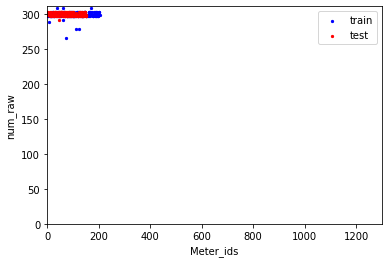

In [71]:
# 전력량 전저리 절차
# 1. 모든 nan -> 0
# 2. 시계열 앞뒤 0인 행은 제거
# 3.1 전력 사용량 있는 곳 중간의 0은 평균값으로 처리 (본인 코드)
# 3.2 전력 사용량 있는 곳 중간의 0은 직전 값으로 처리
# 3.3 전력 사용량 있는 곳 중간의 0은 1주일 전의 평균값으로 처리
# 4. 전력 사용량 24h -> 1d로 합치기
# 5. 1주일 평균값, 1주일 전의 전력량을 feature로 추가
# 진짜 0과 nan->0을 차이를 둘 것인가?

train_2 = train_.copy()
# 1. 모든 nan -> 0
train_2.fillna(0, inplace=True)
columns_ = train_2.columns
meter_ids = columns_[1:]

train_2['Time'] = pd.to_datetime(train_2['Time'], format='%Y.%m.%d %H:%M', errors='raise')

test_2 = test_.copy()
# 1. 모든 nan -> 0
test_2.fillna(0, inplace=True)
columns_2 = test_2.columns
meter_ids_2 = columns_2[1:]

test_2['Time'] = pd.to_datetime(test_2['Time'], format='%Y.%m.%d %H:%M', errors='raise')

import sys
import time

start = time.time()
mod = sys.modules[__name__]

num_met = []
num_raw = []
num_met_test = []
num_raw_test = []
def PreModel(train_2, meter_ids, c1, c2):
    count_ = 0
    day =c1*7
    for meter_id in meter_ids:
        start_idx = 0
        start_sig = 0
        end_idx = 0
        end_sig = 0
        for i in range(len(train_2[meter_id])-1):
            if start_sig == 1 and end_sig == 1:
                break
            if start_sig == 0 and train_2[meter_id].iloc[i] == 0 and train_2[meter_id].iloc[i+1] != 0:
                start_idx = i+1
                start_sig = 1
            if train_2[meter_id].iloc[len(train_2[meter_id])-1] != 0:
                end_idx = len(train_2[meter_id])-1
                end_sig = 1
            if end_sig == 0 and train_2[meter_id].iloc[len(train_2[meter_id])-i-1] == 0 and train_2[meter_id].iloc[len(train_2[meter_id])-i-2] != 0:
                end_idx= len(train_2[meter_id])-i-1
                end_sig = 1
        # 2. 시계열 앞뒤 0인 행 제거
        prepro_ = pd.DataFrame({'date':train_2['Time'].iloc[start_idx:end_idx+1].tolist(), 'power':train_2[meter_id].iloc[start_idx:end_idx+1].tolist()}, columns=['date', 'power'])
        # 3.1 전력 사용량 있는 곳 중간의 0은 평균값으로 처리
        #prepro_.replace(0, prepro_.mean(), inplace=True)
        # 이상치 부분 추가 가능
        # train_list[count_].append(train_2['Time'].iloc[start_idx:end_idx+1].tolist())
        # train_list[count_].append(train_2[meter_id].iloc[start_idx:end_idx+1].tolist())
        
        
         #중간 결측치를 바로 전값으로 채움
        for i in range(len(prepro_)):
            #print("before:", prepro_['power'].iloc[i])
            if prepro_['power'].iloc[i] == 0.0:
                 prepro_['power'].iloc[i] == prepro_['power'].iloc[i-1]
            #print("after:", prepro_['power'].iloc[i])
        
        
        # power_d (직전 7d의 평균) feature 추가
        # power_d1, d2, ..., d7 feature 추가
        
        if len(prepro_) > 6000 and len(prepro_) < 8400:
            return_ = add_feature(prepro_, day) # 1주 2주 3주 바꾸실 때 이놈만 수정하시면 됩니다.
            # 전력 사용량 24h -> 1d로 합치기   
            if c2 == 0:
                num_raw.append(len(return_))
                num_met.append(count_+1)
            else:
                num_raw_test.append(len(return_))
                num_met_test.append(count_+1)

            final_add = pd.merge(weather_d_final, return_, on='date')
            if count_ == 0:
                final_ans = final_add.copy()
            else:
                final_ans = pd.concat([final_ans, final_add], ignore_index=True)
                final_ans.reset_index()
            count_ = count_ + 1
            if count_%100 == 0:
                print(count_, "세대, 계산 시간 : ", time.time() - start)
            #print(return_)
    if count_ != 0:
        return final_ans
            
    
# c1 : 1 = 1주일, 2 = 2주일, 3 = 3주일
# c2 : 0 = train, 1 = test
final_ans = PreModel(train_2, meter_ids, 1, 0)
final_ans_test = PreModel(test_2, meter_ids_2, 1, 1)
#PreModel(train_2, meter_ids, mod, 2)
#PreModel(train_2, meter_ids, mod, 3)


plt.scatter(num_met, num_raw, s=5, color='b', label='train')
plt.scatter(num_met_test, num_raw_test, s=5, color='r', label='test')
plt.legend()
plt.xlim(0, 1300)
plt.ylim(bottom=0)
plt.xlabel('Meter_ids')
plt.ylabel('num_raw')
plt.show()

# 추가로 고려해야 하는 변수 : 직전 7d 표준편차


# NaN에 구간 평균값 사용

In [ ]:
# 전력량 전저리 절차
# 1. 모든 nan -> 0
# 2. 시계열 앞뒤 0인 행은 제거
# 3.1 전력 사용량 있는 곳 중간의 0은 평균값으로 처리 (본인 코드)
# 3.2 전력 사용량 있는 곳 중간의 0은 직전 값으로 처리
# 3.3 전력 사용량 있는 곳 중간의 0은 1주일 전의 평균값으로 처리
# 4. 전력 사용량 24h -> 1d로 합치기
# 5. 1주일 평균값, 1주일 전의 전력량을 feature로 추가
# 진짜 0과 nan->0을 차이를 둘 것인가?

train_2 = train_.copy()
# 1. 모든 nan -> 0
train_2.fillna(0, inplace=True)
columns_ = train_2.columns
meter_ids = columns_[1:]

train_2['Time'] = pd.to_datetime(train_2['Time'], format='%Y.%m.%d %H:%M', errors='raise')

test_2 = test_.copy()
# 1. 모든 nan -> 0
test_2.fillna(0, inplace=True)
columns_2 = test_2.columns
meter_ids_2 = columns_2[1:]

test_2['Time'] = pd.to_datetime(test_2['Time'], format='%Y.%m.%d %H:%M', errors='raise')

#import sys
import time

start = time.time()
#mod = sys.modules[__name__]

num_met = []
num_raw = []
num_met_test = []
num_raw_test = []
def PreModel_section(train_2, meter_ids, c1, c2):
    count_ = 0
    day =c1*7
    for meter_id in meter_ids:
        start_idx = 0
        start_sig = 0
        end_idx = 0
        end_sig = 0
        for i in range(len(train_2[meter_id])-1):
            if start_sig == 1 and end_sig == 1:
                break
            if start_sig == 0 and train_2[meter_id].iloc[i] == 0 and train_2[meter_id].iloc[i+1] != 0:
                start_idx = i+1
                start_sig = 1
            if train_2[meter_id].iloc[len(train_2[meter_id])-1] != 0:
                end_idx = len(train_2[meter_id])-1
                end_sig = 1
            if end_sig == 0 and train_2[meter_id].iloc[len(train_2[meter_id])-i-1] == 0 and train_2[meter_id].iloc[len(train_2[meter_id])-i-2] != 0:
                end_idx= len(train_2[meter_id])-i-1
                end_sig = 1
        # 2. 시계열 앞뒤 0인 행 제거
        prepro_ = pd.DataFrame({'date':train_2['Time'].iloc[start_idx:end_idx+1].tolist(), 'power':train_2[meter_id].iloc[start_idx:end_idx+1].tolist()}, columns=['date', 'power'])
        # 3.1 전력 사용량 있는 곳 중간의 0은 평균값으로 처리
        #prepro_.replace(0, prepro_.mean(), inplace=True)
        # 이상치 부분 추가 가능
        # train_list[count_].append(train_2['Time'].iloc[start_idx:end_idx+1].tolist())
        # train_list[count_].append(train_2[meter_id].iloc[start_idx:end_idx+1].tolist())
        
        
        #중간 결측치를 바로 전값으로 채움
        #for i in range(len(prepro_)):
            #print("before:", prepro_['power'].iloc[i])
        #    if prepro_['power'].iloc[i] == 0.0:
        #         prepro_['power'].iloc[i] == prepro_['power'].iloc[i-1]
            #print("after:", prepro_['power'].iloc[i])
        
        # 3.3 전력 사용량 있는 곳 중간의 0은 1주일 전의 평균값으로 처리
        for i in range(len(prepro_)):
            if prepro_.loc[i, 'power'] == 0:
                prepro_.loc[i, 'power'] = sum(prepro_.loc[i-7:i, 'power'].values)/7
        
        # power_d (직전 7d의 평균) feature 추가
        # power_d1, d2, ..., d7 feature 추가
        if c1 == 1:
            if len(prepro_) > 6000 and len(prepro_) < 8400:
                return_ = add_feature(prepro_, day) # 1주 2주 3주 바꾸실 때 이놈만 수정하시면 됩니다.
                # 전력 사용량 24h -> 1d로 합치기   
                if c2 == 0:
                    num_raw.append(len(return_))
                    num_met.append(count_+1)
                else:
                    num_raw_test.append(len(return_))
                    num_met_test.append(count_+1)
        
                final_add = pd.merge(weather_d_final, return_, on='date')
                if count_ == 0:
                    final_ans = final_add.copy()
                else:
                    final_ans = pd.concat([final_ans, final_add], ignore_index=True)
                    final_ans.reset_index()
                count_ = count_ + 1
                if count_%100 == 0:
                    print(count_, "세대, 계산 시간 : ", time.time() - start)
                #print(return_)
    if count_ != 0:
        return final_ans
            
    
# c1 : 1 = 1주일, 2 = 2주일, 3 = 3주일
# c2 : 0 = train, 1 = test
final_ans = PreModel(train_2, meter_ids, 1, 0)
final_ans_test = PreModel(test_2, meter_ids_2, 1, 1)
#PreModel(train_2, meter_ids, mod, 2)
#PreModel(train_2, meter_ids, mod, 3)


plt.scatter(num_met, num_raw, s=5, color='b', label='train')
plt.scatter(num_met_test, num_raw_test, s=5, color='r', label='test')
plt.legend()
plt.xlim(0, 1300)
plt.ylim(bottom=0)
plt.xlabel('Meter_ids')
plt.ylabel('num_raw')
plt.show()

# 추가로 고려해야 하는 변수 : 직전 7d 표준편차


# final_ans : TRAIN 최종본
# final_ans_test : TEST 최종본

In [72]:
final_ans.to_csv("before_1week.csv", mode='w', index=False)
print(final_ans)
final_ans_test.to_csv("before_1week_test.csv", mode='w', index=False)
print(final_ans_test)

             date  avg_temp  min_temp  max_temp  rain_d    wind_d      wet_d  \
0      2017-09-05      22.5      21.4      23.7     0.0  2.016667  63.500000   
1      2017-09-06      20.8      18.7      23.1     1.9  1.533333  82.458333   
2      2017-09-07      22.2      18.4      25.8     0.0  2.095833  80.083333   
3      2017-09-08      23.6      21.2      27.4     0.0  1.925000  77.833333   
4      2017-09-09      23.4      20.7      27.1     0.0  2.004167  80.958333   
...           ...       ...       ...       ...     ...       ...        ...   
61014  2018-06-26      21.3      19.4      24.0     5.8  3.820833  90.166667   
61015  2018-06-27      20.5      18.5      23.0     0.2  2.583333  93.625000   
61016  2018-06-28      22.3      20.0      25.1     2.4  2.250000  93.583333   
61017  2018-06-29      22.3      20.0      26.0     0.4  1.879167  90.208333   
61018  2018-06-30      24.0      19.5      28.5     0.0  1.395833  84.916667   

       snow_d  year month  ... holiday 

# 전처리 총 경우의 수

# 전력량 결측치 표현법 : 1) 전체 평균 2) 구간 평균 3) 직전값

# 속성 추가 : 1) 1주일 평균 + 1주일 전력량 2) 2주일 3) 3주일

# 예시 : 1개 세대에 대한 train data(X, Y)

In [215]:
problem_1 = pd.merge(weather_d_final, model_1, on='date', how='right')
print(problem_1.dtypes)
problem_1.to_csv("model_1.csv", mode='w')
problem_1

date           object
avg_temp      float64
min_temp      float64
max_temp      float64
rain_d        float64
wind_d        float64
wet_d         float64
snow_d        float64
year         category
month        category
week         category
day          category
dayofweek    category
weekend      category
holiday      category
power_d       float64
power_d7      float64
power_d6      float64
power_d5      float64
power_d4      float64
power_d3      float64
power_d2      float64
power_d1      float64
power         float64
dtype: object


,date,avg_temp,min_temp,max_temp,rain_d,wind_d,wet_d,snow_d,year,month,...,holiday,power_d,power_d7,power_d6,power_d5,power_d4,power_d3,power_d2,power_d1,power
0,2018-02-22,1.6,-2.3,5.3,0.0,3.904167,65.333333,0.0,2018,2,...,0.0,0.455221,0.309864,0.275739,0.417655,0.643364,0.574697,0.461405,0.503822,0.519280
1,2018-02-23,3.9,0.7,7.5,4.5,3.383333,88.250000,27.3,2018,2,...,0.0,0.485138,0.275739,0.417655,0.643364,0.574697,0.461405,0.503822,0.519280,0.464352
2,2018-02-24,1.3,-0.9,4.6,0.0,3.062500,59.708333,0.0,2018,2,...,0.0,0.512082,0.417655,0.643364,0.574697,0.461405,0.503822,0.519280,0.464352,0.600822
3,2018-02-25,0.4,-2.2,5.1,0.0,2.945833,51.916667,0.0,2018,2,...,0.0,0.538249,0.643364,0.574697,0.461405,0.503822,0.519280,0.464352,0.600822,0.490686
4,2018-02-26,1.7,-2.6,6.3,0.0,2.025000,53.541667,0.0,2018,2,...,0.0,0.516438,0.574697,0.461405,0.503822,0.519280,0.464352,0.600822,0.490686,0.595280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2018-06-25,24.7,20.3,29.0,0.0,1.933333,71.833333,0.0,2018,6,...,0.0,0.395249,0.518618,0.350292,0.367708,0.341167,0.320000,0.373458,0.495500,0.371208
124,2018-06-26,21.3,19.4,24.0,90.3,4.466667,90.166667,0.0,2018,6,...,0.0,0.374190,0.350292,0.367708,0.341167,0.320000,0.373458,0.495500,0.371208,0.424792
125,2018-06-27,20.5,18.5,23.0,0.2,2.583333,93.625000,0.0,2018,6,...,0.0,0.384833,0.367708,0.341167,0.320000,0.373458,0.495500,0.371208,0.424792,0.435239
126,2018-06-28,22.3,20.0,25.1,2.4,2.250000,93.583333,0.0,2018,6,...,0.0,0.394481,0.341167,0.320000,0.373458,0.495500,0.371208,0.424792,0.435239,0.427167


# EDA

In [3]:
final_1 = pd.read_csv("section_2week.csv")
final_2 = pd.read_csv("section_2week_test.csv")
final_con = pd.concat([final_1, final_2], ignore_index=True)
final_con.reset_index()
final_con

,date,avg_temp,min_temp,max_temp,rain_d,wind_d,wet_d,snow_d,year,month,...,power_d9,power_d8,power_d7,power_d6,power_d5,power_d4,power_d3,power_d2,power_d1,power
0,2017-09-12,22.5,20.0,26.0,0.0,3.441667,63.666667,0.0,2017,9,...,0.138917,0.177417,0.181292,0.170667,0.166458,0.146000,0.250613,0.192000,0.177125,0.180385
1,2017-09-13,21.3,18.0,24.9,0.0,3.033333,53.750000,0.0,2017,9,...,0.177417,0.181292,0.170667,0.166458,0.146000,0.250613,0.192000,0.177125,0.180385,0.101750
2,2017-09-14,22.1,16.8,26.3,0.0,2.970833,52.166667,0.0,2017,9,...,0.181292,0.170667,0.166458,0.146000,0.250613,0.192000,0.177125,0.180385,0.101750,0.094250
3,2017-09-15,23.0,19.4,26.6,0.0,4.241667,49.208333,0.0,2017,9,...,0.170667,0.166458,0.146000,0.250613,0.192000,0.177125,0.180385,0.101750,0.094250,0.089750
4,2017-09-16,22.2,17.2,26.3,0.0,4.525000,51.125000,0.0,2017,9,...,0.166458,0.146000,0.250613,0.192000,0.177125,0.180385,0.101750,0.094250,0.089750,0.097958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104084,2018-06-26,21.3,19.4,24.0,5.8,3.820833,90.166667,0.0,2018,6,...,0.313599,0.359879,0.393125,0.342542,0.340542,0.339744,0.482649,0.428500,0.381667,0.370125
104085,2018-06-27,20.5,18.5,23.0,0.2,2.583333,93.625000,0.0,2018,6,...,0.359879,0.393125,0.342542,0.340542,0.339744,0.482649,0.428500,0.381667,0.370125,0.307042
104086,2018-06-28,22.3,20.0,25.1,2.4,2.250000,93.583333,0.0,2018,6,...,0.393125,0.342542,0.340542,0.339744,0.482649,0.428500,0.381667,0.370125,0.307042,0.365125
104087,2018-06-29,22.3,20.0,26.0,0.4,1.879167,90.208333,0.0,2018,6,...,0.342542,0.340542,0.339744,0.482649,0.428500,0.381667,0.370125,0.307042,0.365125,0.269702


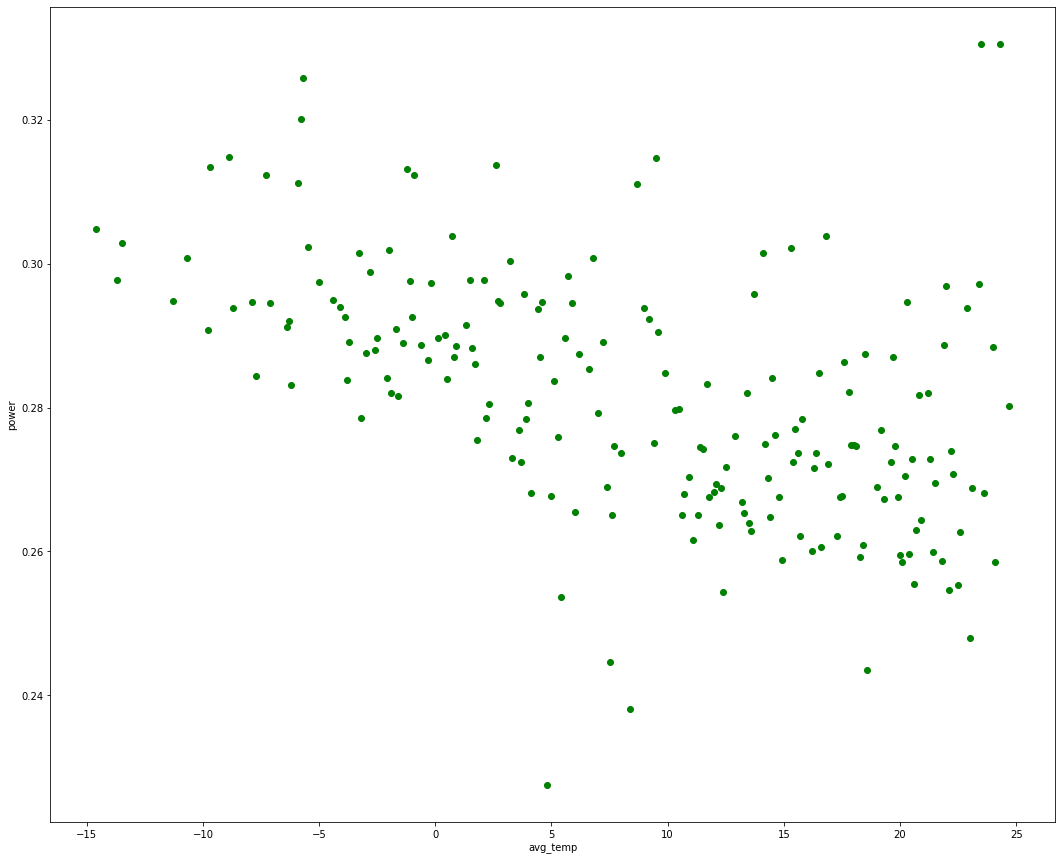

In [123]:
plt.rcParams['figure.figsize'] = [18, 15]
plt.plot(final_con.groupby('avg_temp').mean()['power'], 'go')
plt.xlabel('avg_temp')
plt.ylabel('power')
plt.show()

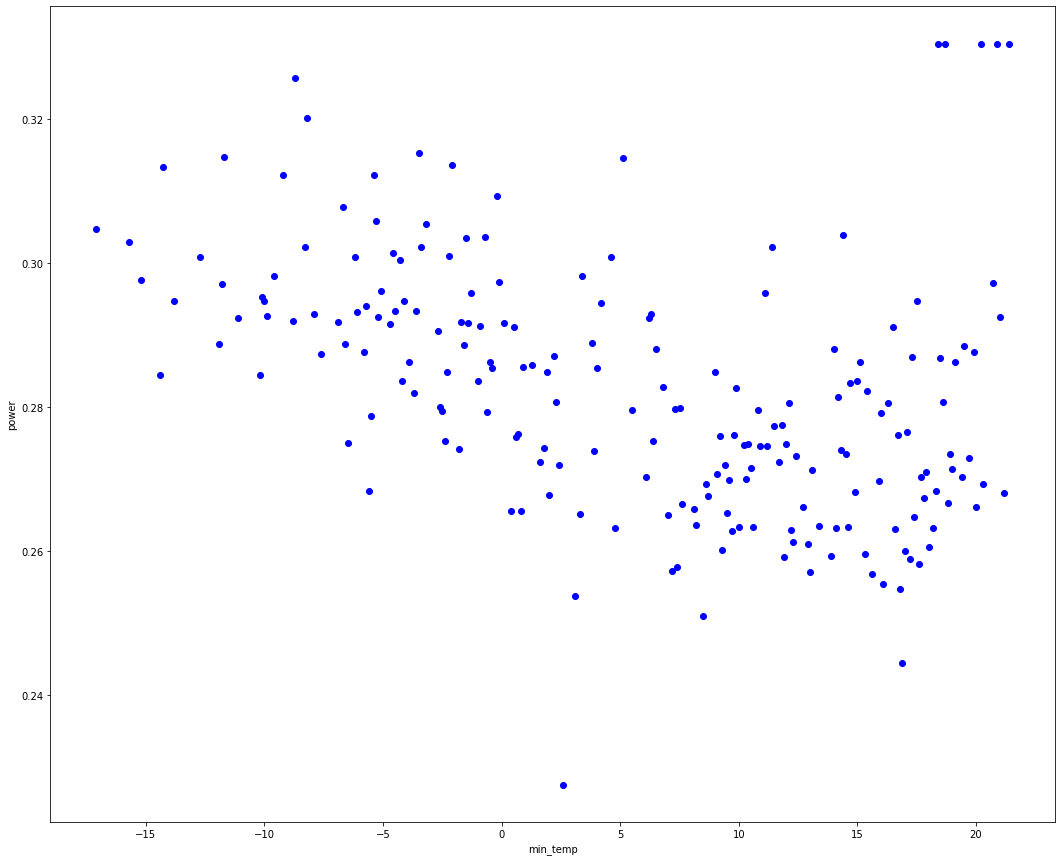

In [98]:
plt.plot(final_con.groupby('min_temp').mean()['power'], 'bo')
plt.xlabel('min_temp')
plt.ylabel('power')
plt.show()

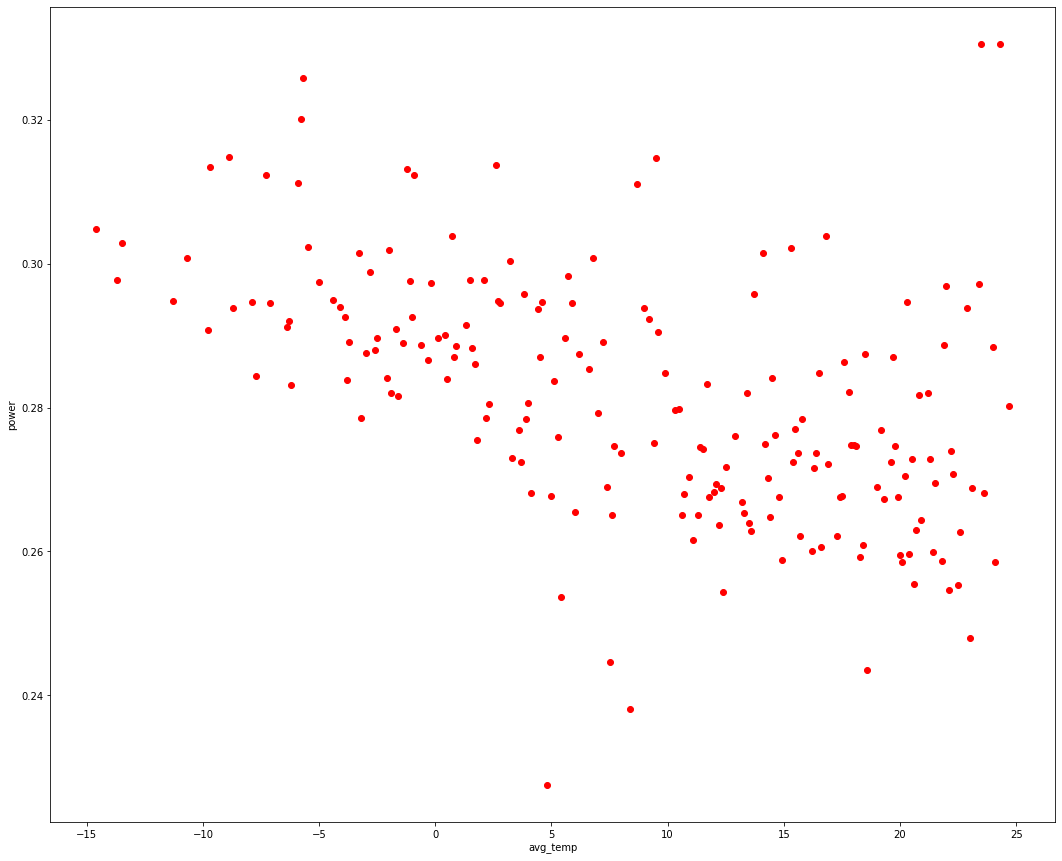

In [99]:
plt.plot(final_con.groupby('avg_temp').mean()['power'], 'ro')
plt.xlabel('avg_temp')
plt.ylabel('power')
plt.show()

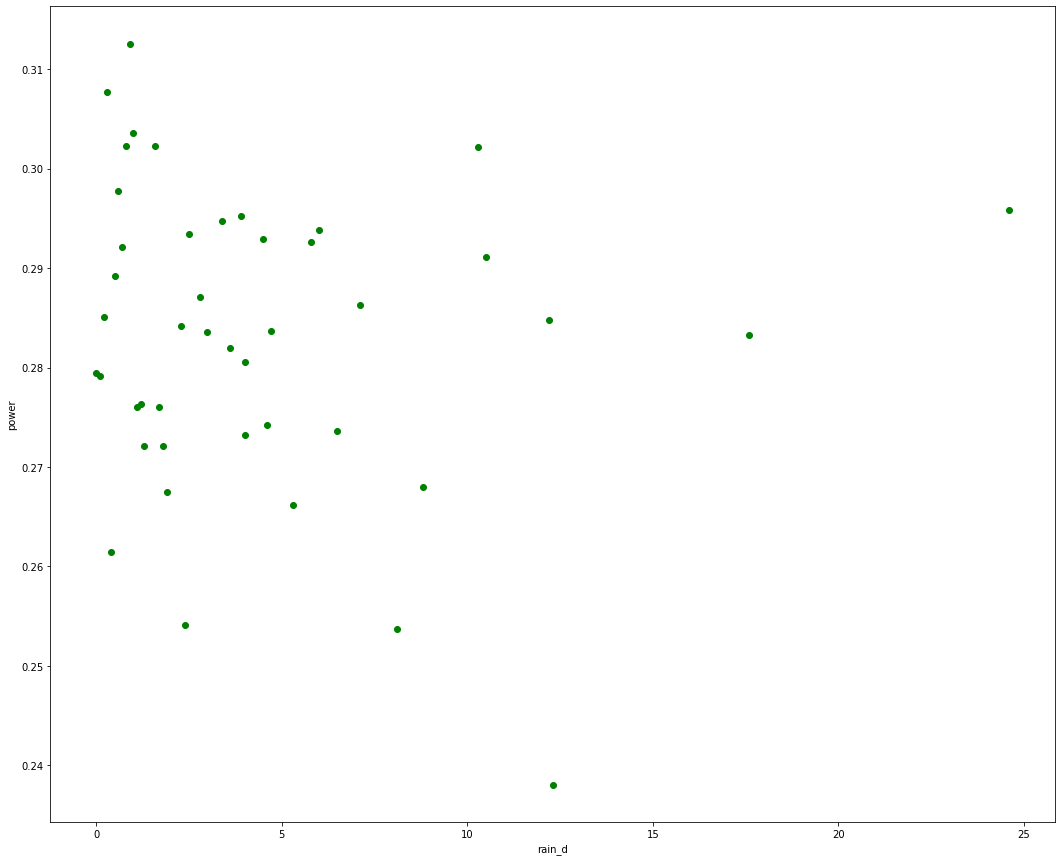

In [100]:
plt.plot(final_con.groupby('rain_d').mean()['power'], 'go')
plt.xlabel('rain_d')
plt.ylabel('power')
plt.show()

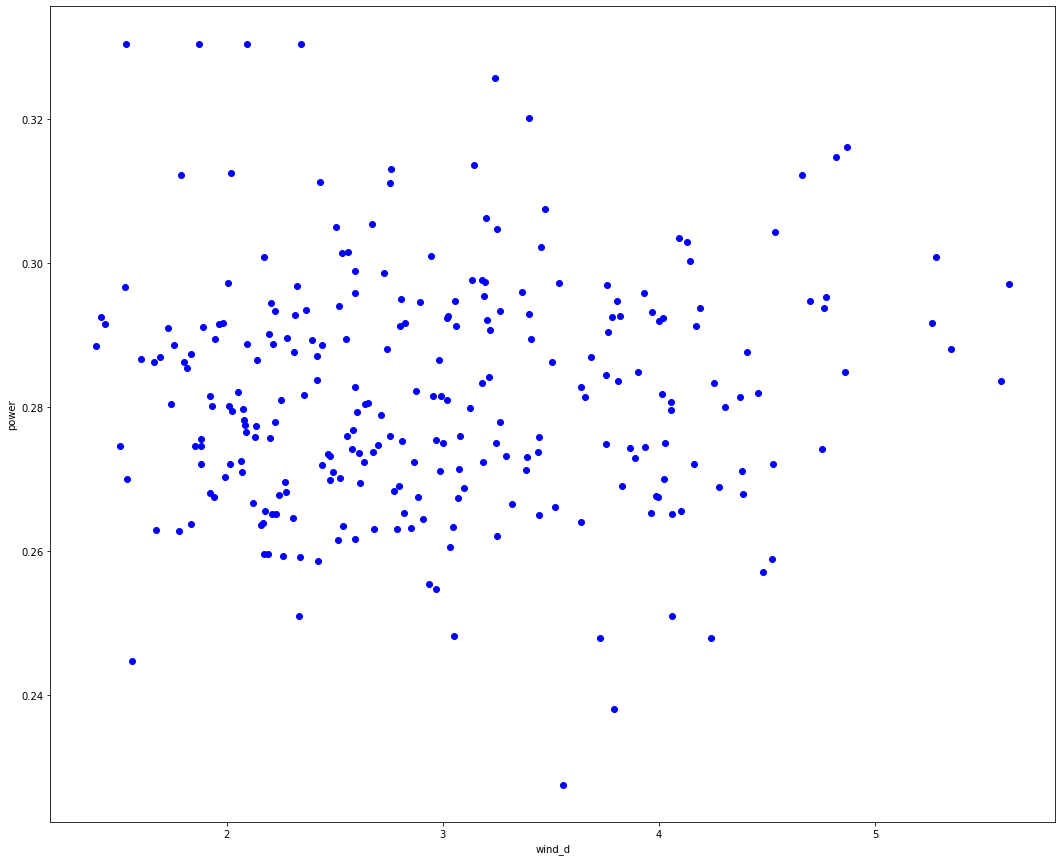

In [101]:
plt.plot(final_con.groupby('wind_d').mean()['power'], 'bo')
plt.xlabel('wind_d')
plt.ylabel('power')
plt.show()

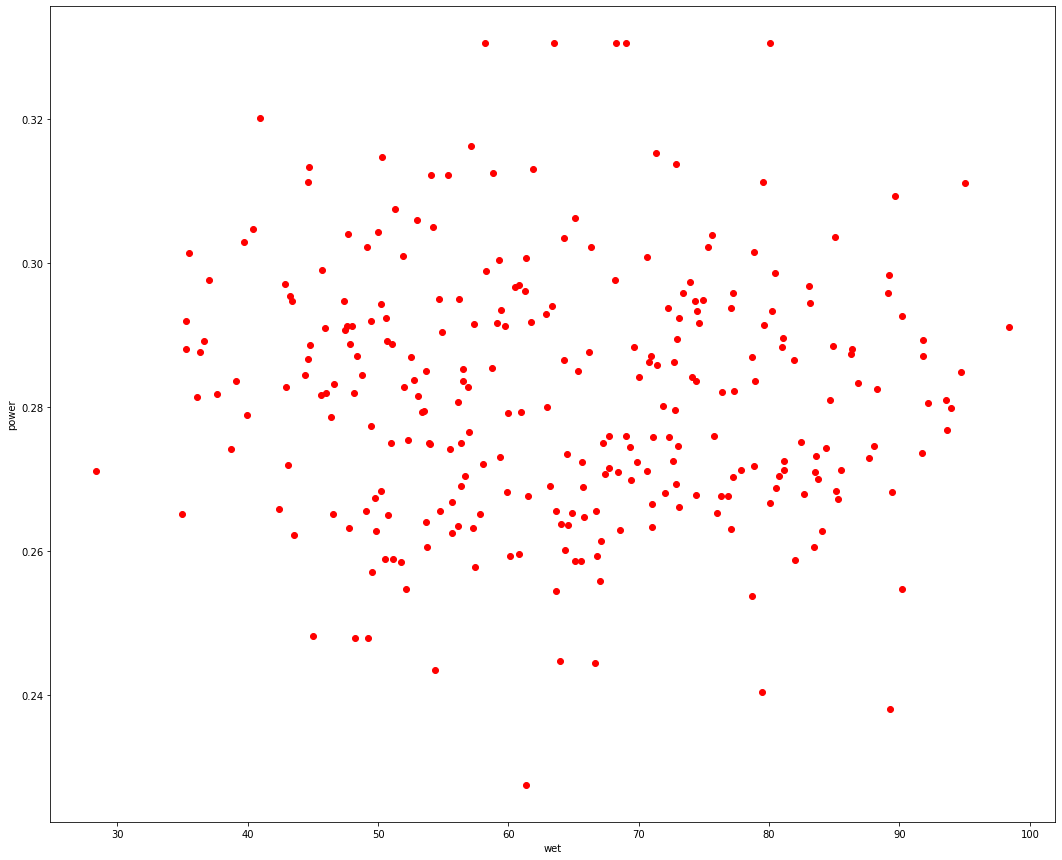

In [102]:
plt.plot(final_con.groupby('wet_d').mean()['power'], 'ro')
plt.xlabel('wet')
plt.ylabel('power')
plt.show()

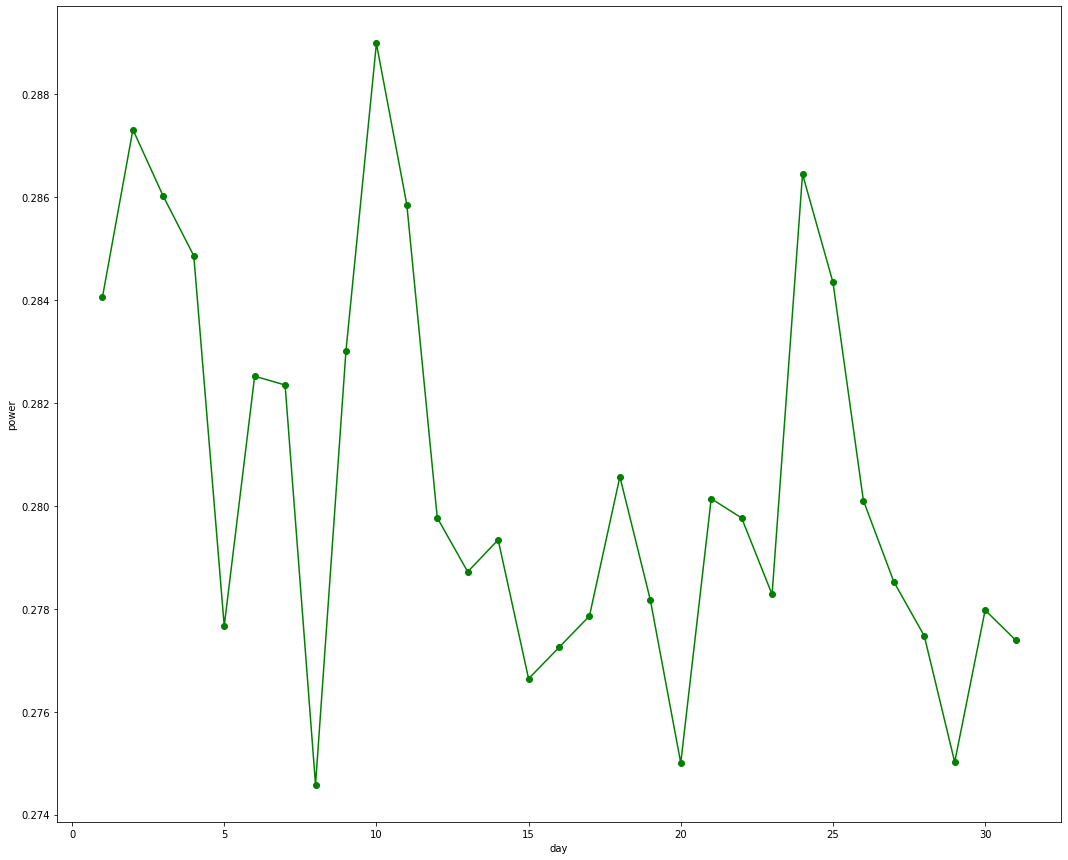

In [103]:
plt.plot(final_con.groupby('day').mean()['power'], 'go-')
plt.xlabel('day')
plt.ylabel('power')
plt.show()

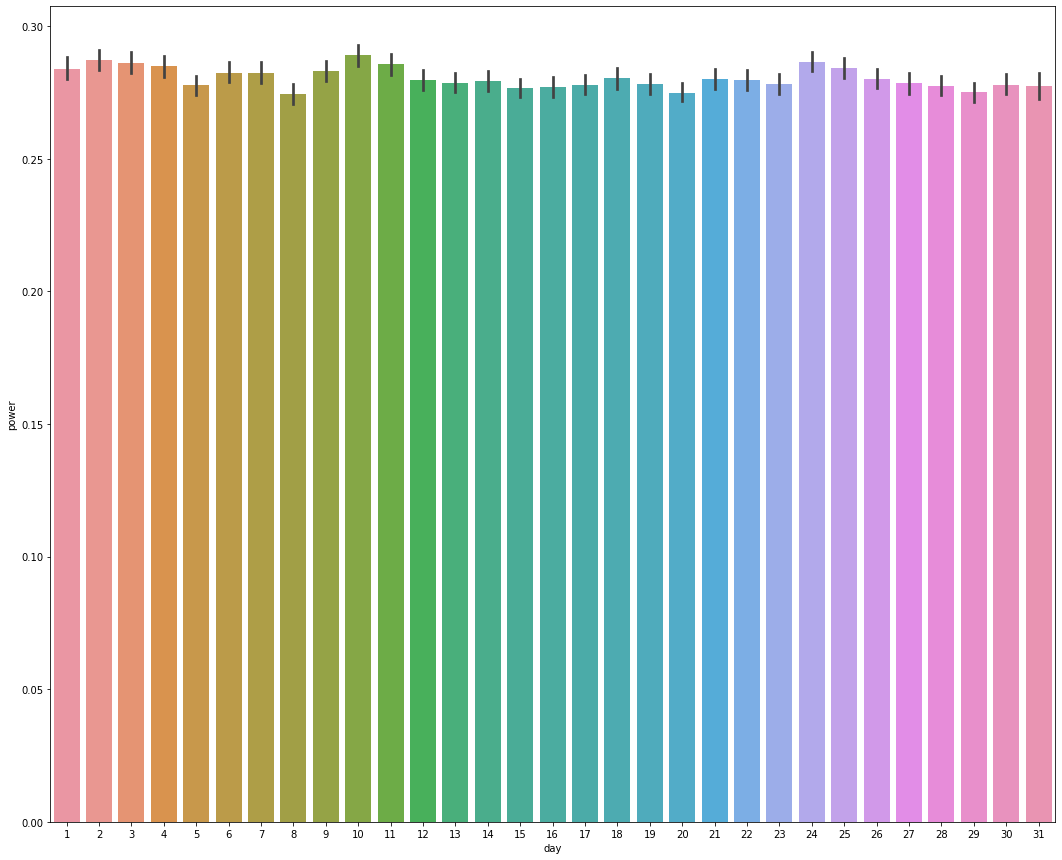

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.barplot(data=final_con, x='day', y='power', ax=ax)
plt.show()

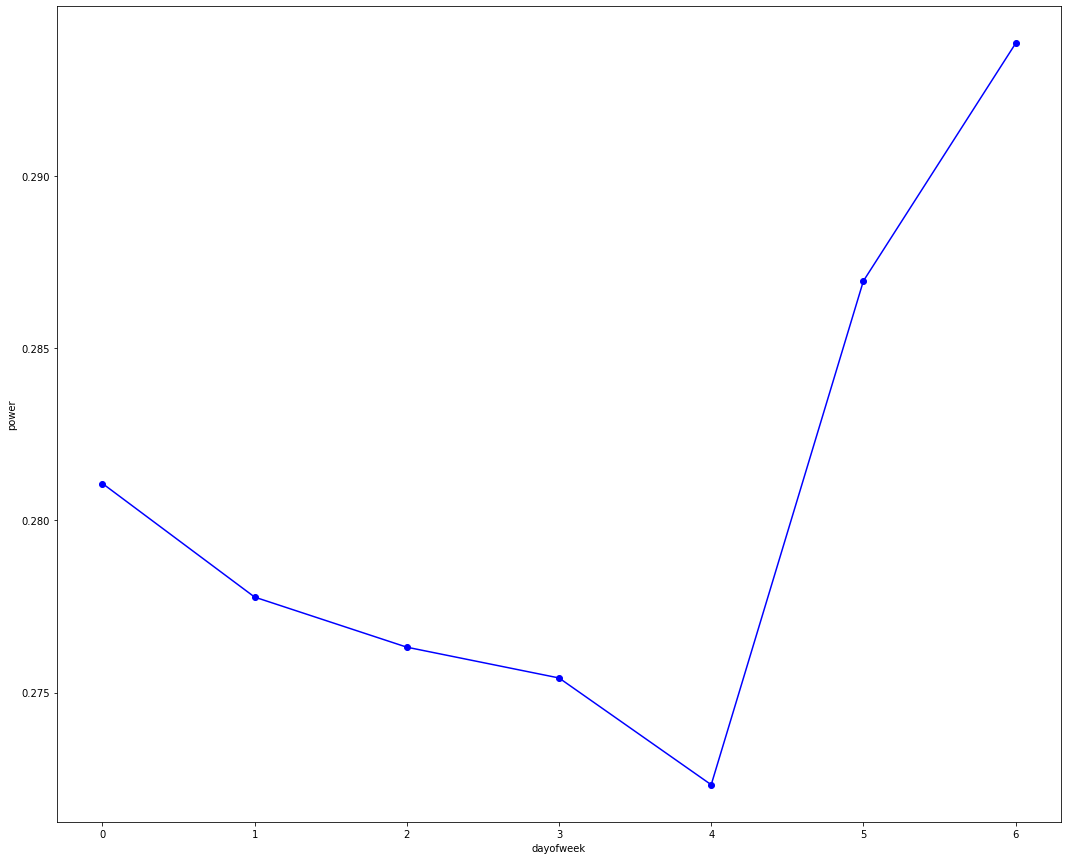

In [105]:
plt.plot(final_con.groupby('dayofweek').mean()['power'], 'bo-')
plt.xlabel('dayofweek')
plt.ylabel('power')
plt.show()

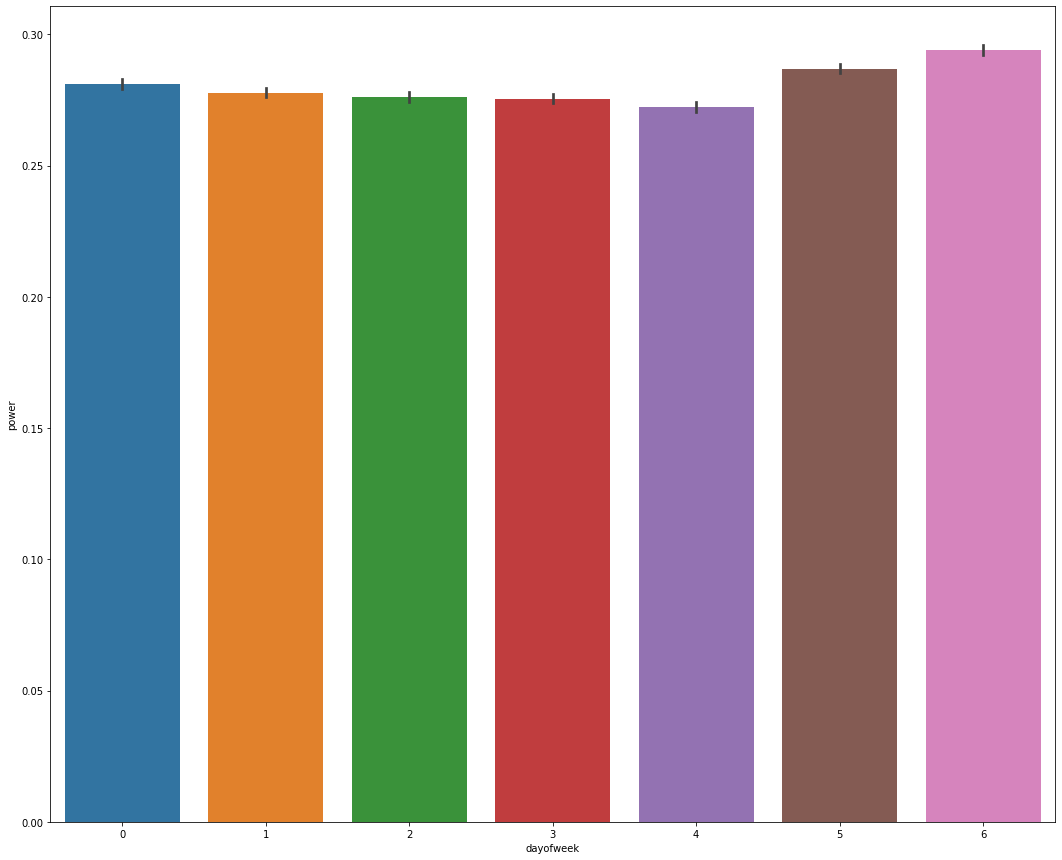

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.barplot(data=final_con, x='dayofweek', y='power', ax=ax)
plt.show()

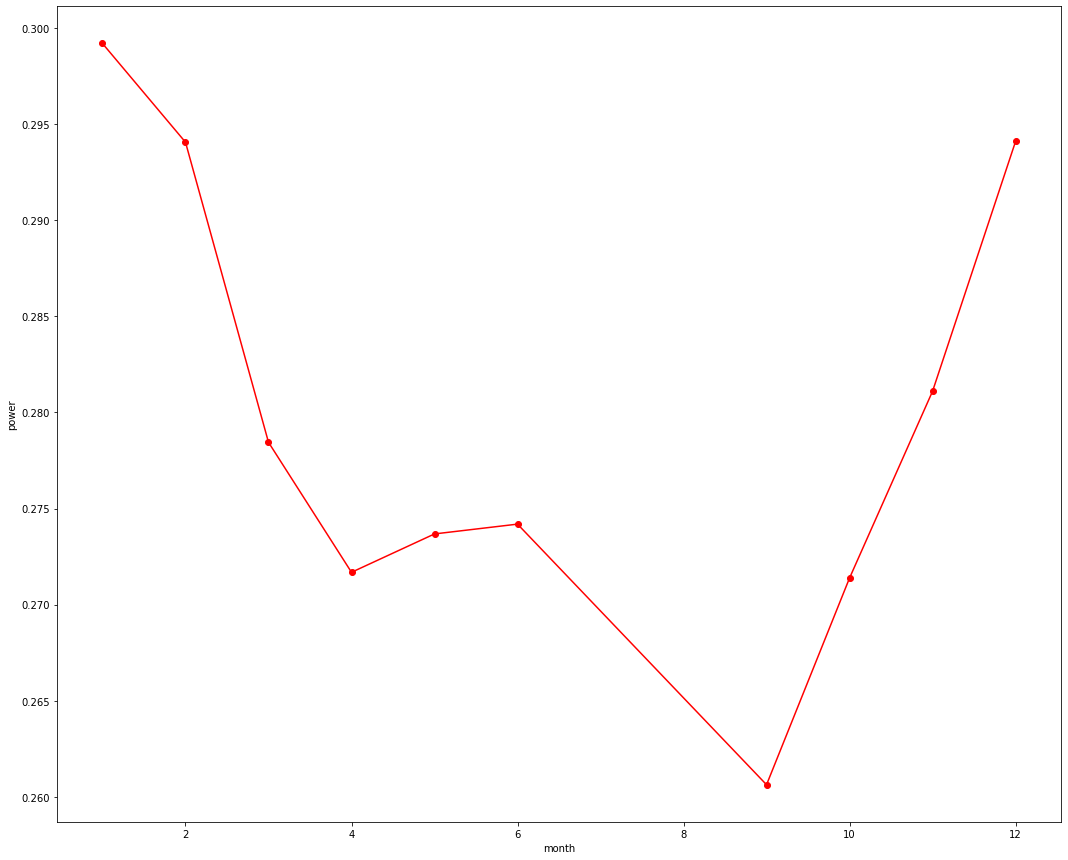

In [107]:
plt.plot(final_con.groupby('month').mean()['power'], 'ro-')
plt.xlabel('month')
plt.ylabel('power')
plt.show()

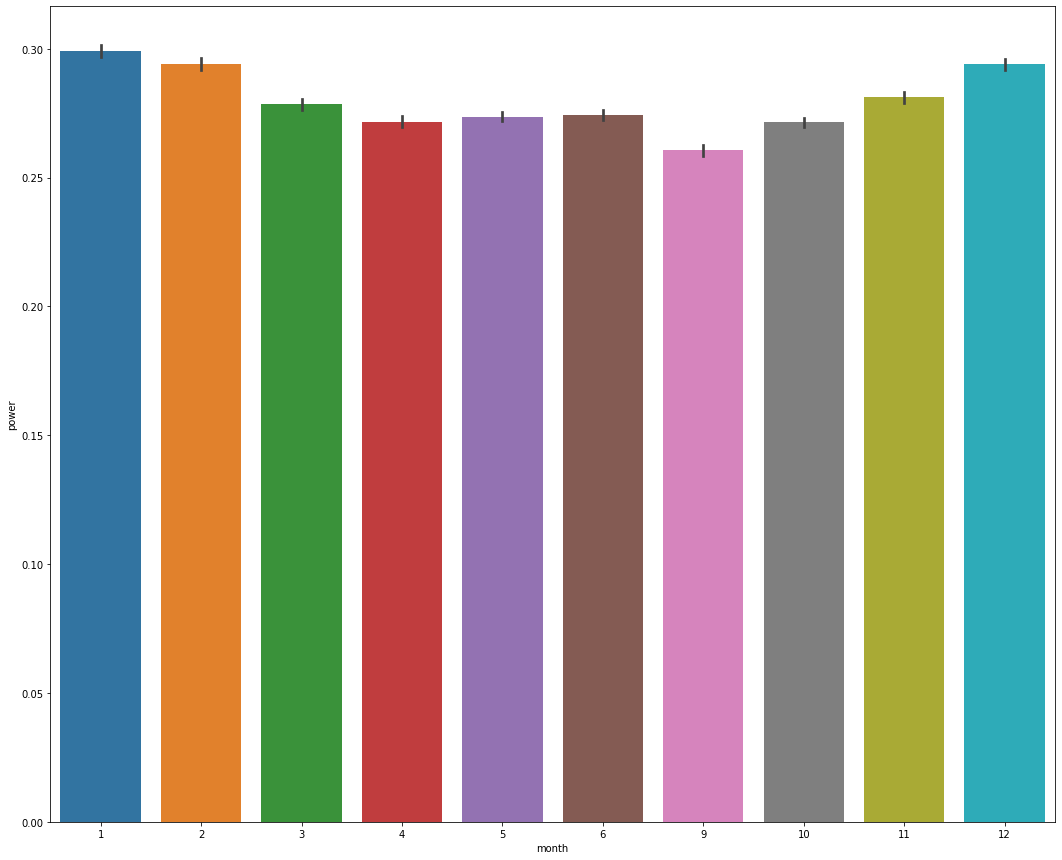

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.barplot(data=final_con, x='month', y='power', ax=ax)
plt.show()

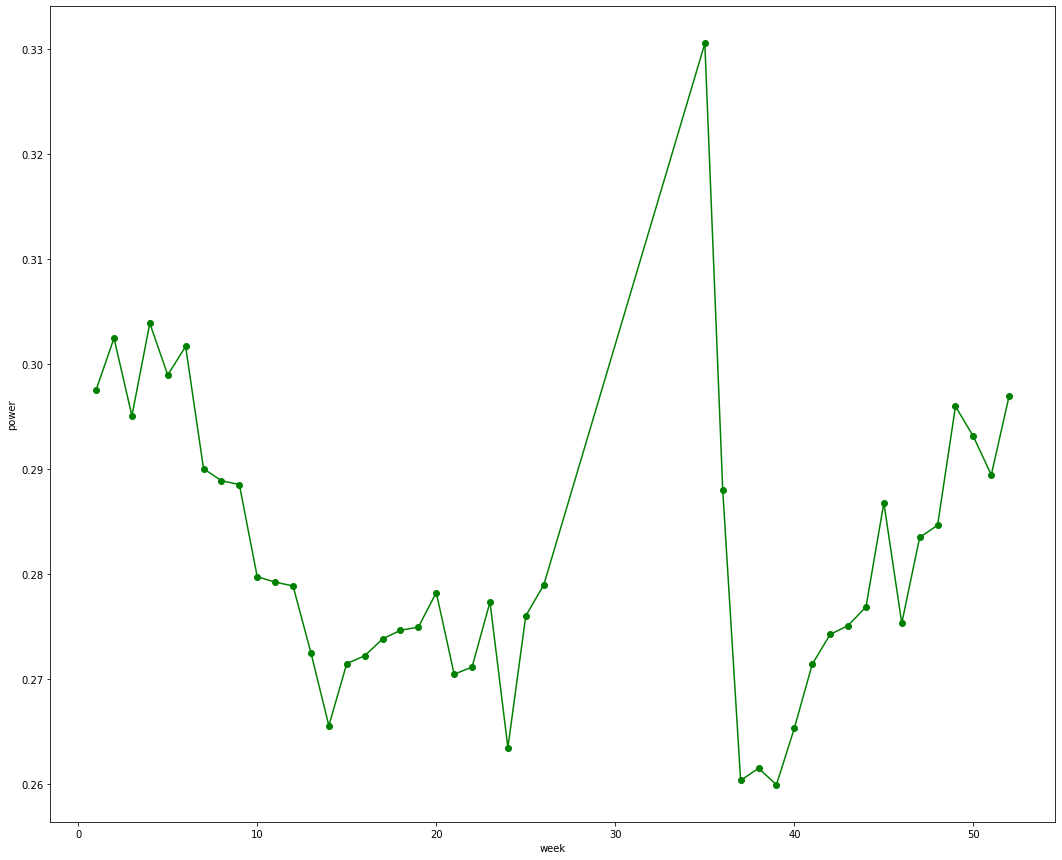

In [109]:
plt.plot(final_con.groupby('week').mean()['power'], 'go-')
plt.xlabel('week')
plt.ylabel('power')
plt.show()

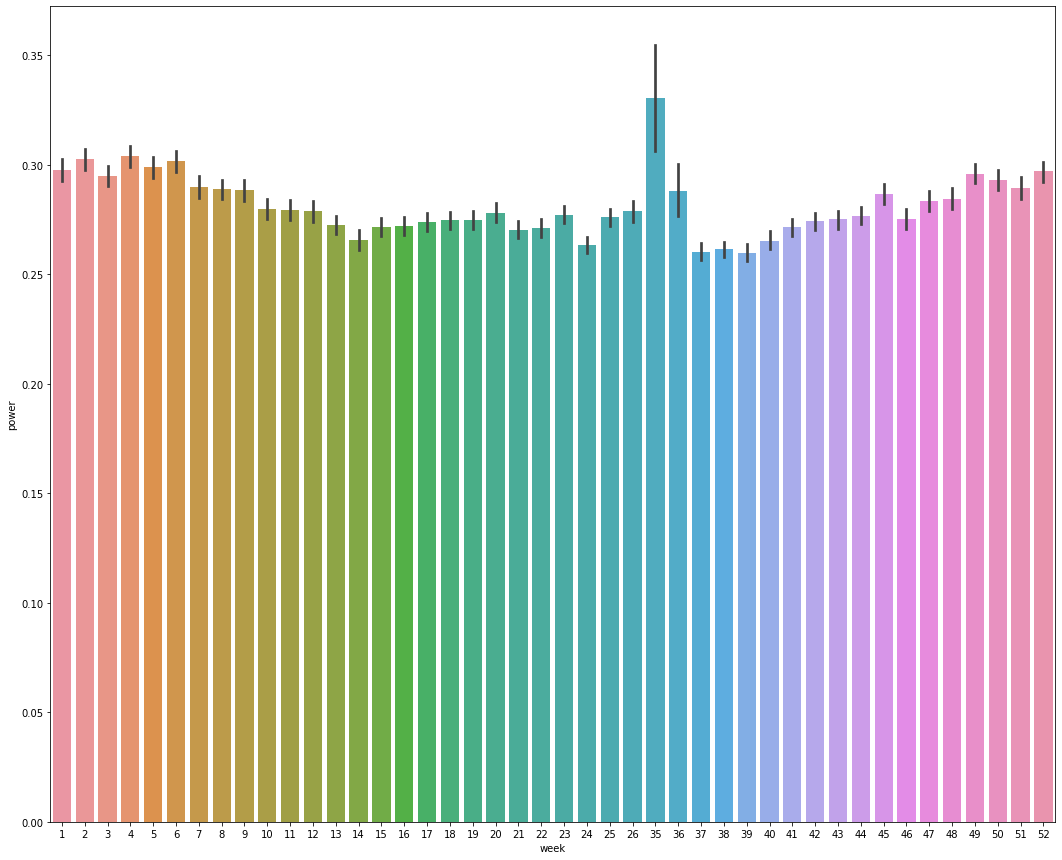

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.barplot(data=final_con, x='week', y='power', ax=ax)
plt.show()

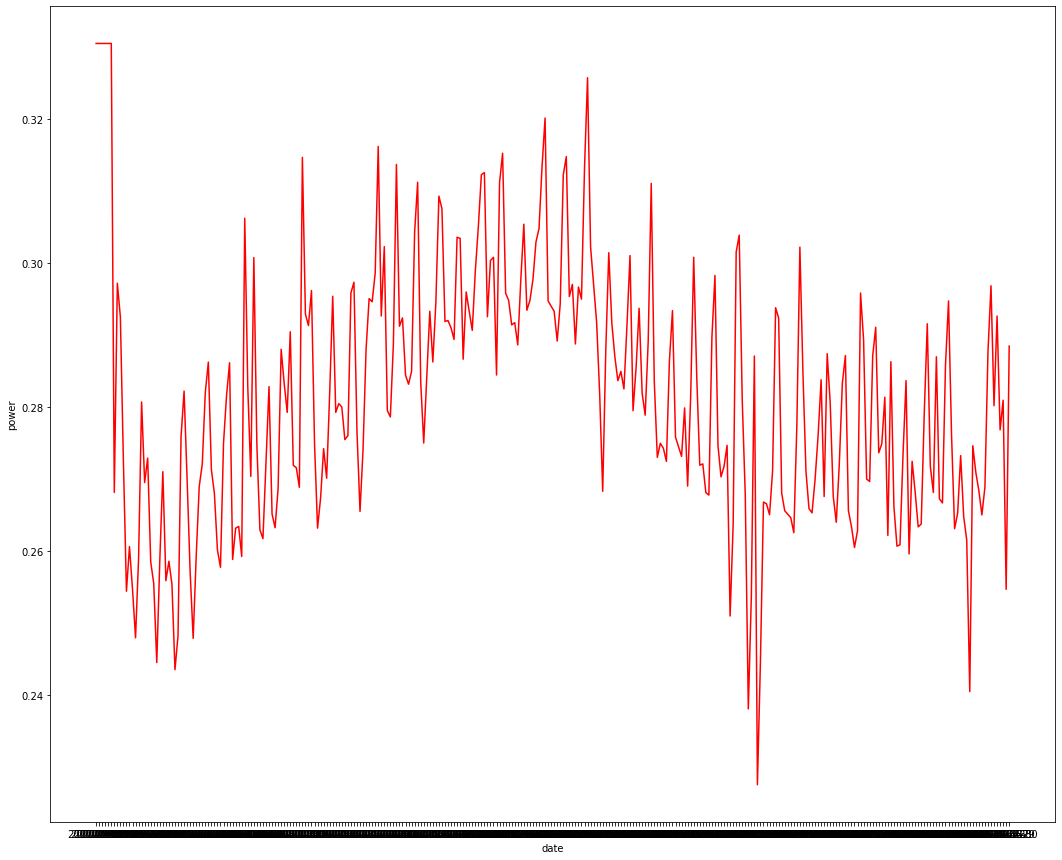

In [124]:
plt.plot(final_con.groupby('date').mean()['power'], 'r-')
plt.xlabel('date')
plt.ylabel('power')
plt.show()

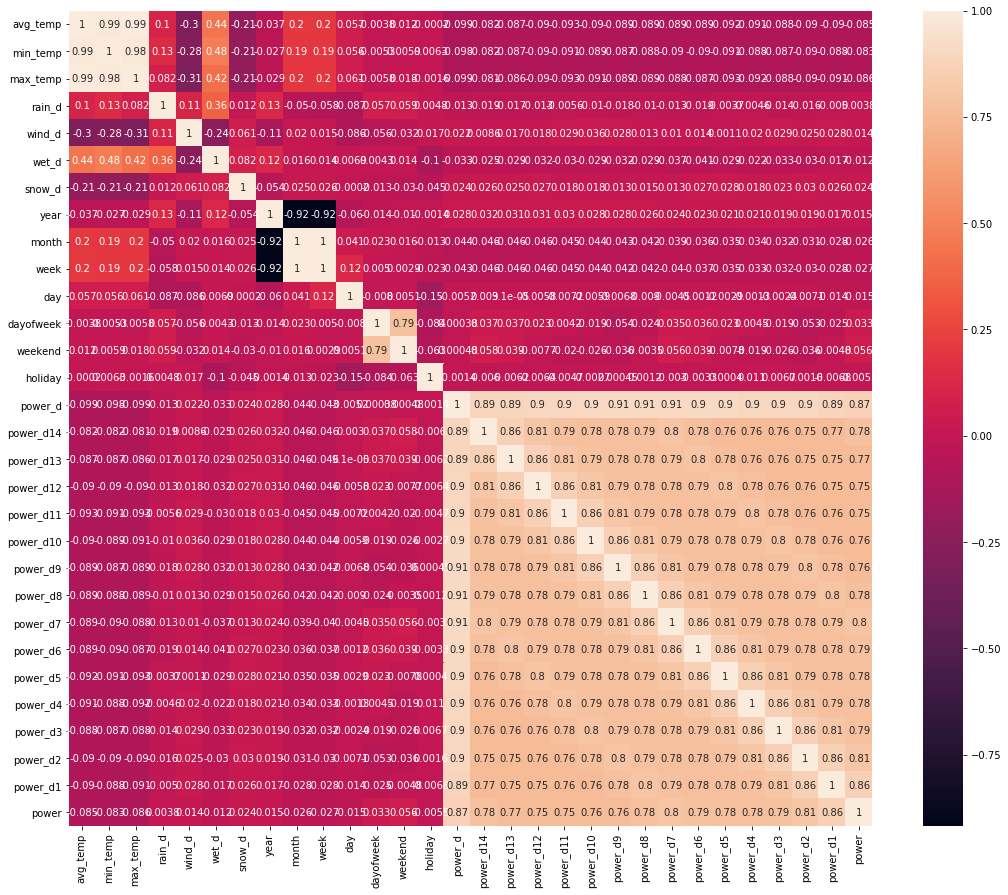

In [113]:
sns.heatmap(final_con.corr(), annot = True)

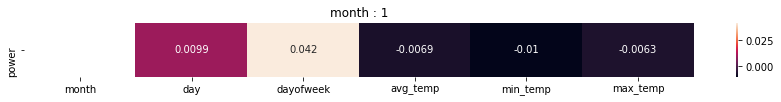

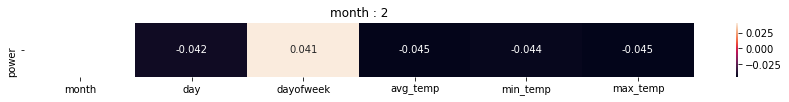

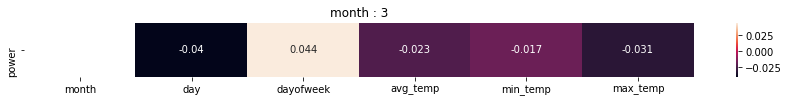

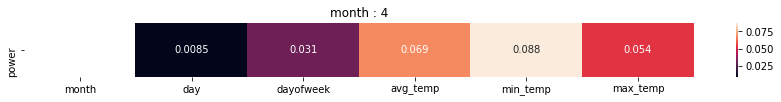

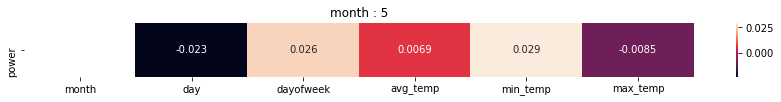

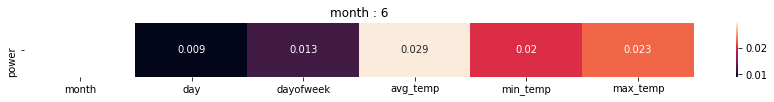

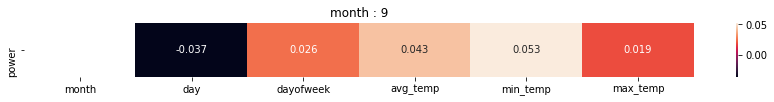

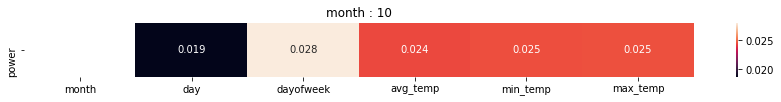

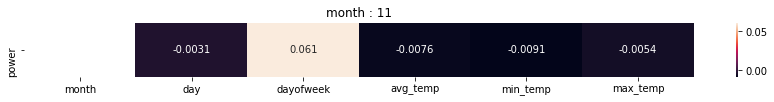

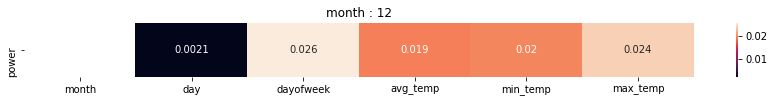

In [125]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    if m != 7 and m != 8:
        sns.heatmap(final_con[final_con['month']== m].corr().loc[['power'],['month', 'day', 'dayofweek', 'avg_temp', 'min_temp', 'max_temp']], annot=True)
        plt.title('month : '+ str(m))
        plt.show()

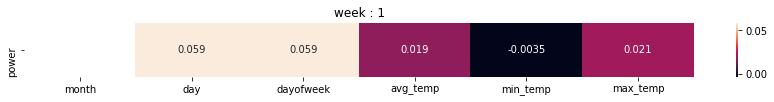

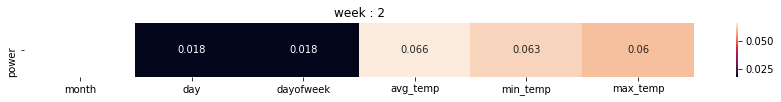

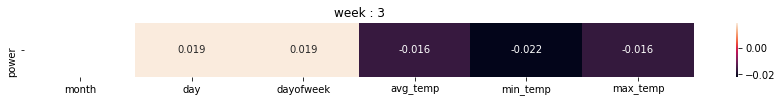

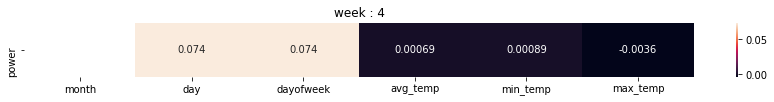

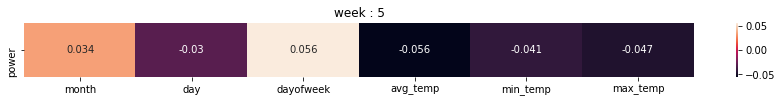

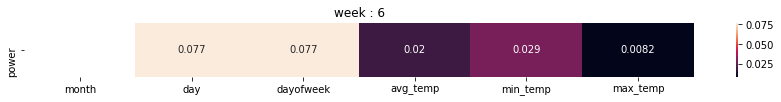

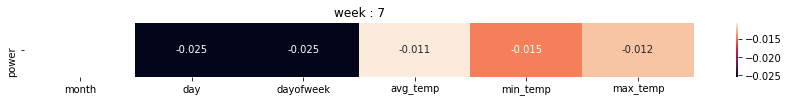

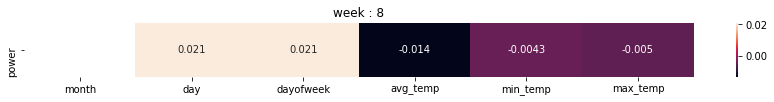

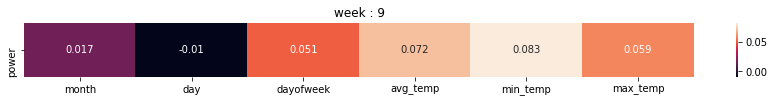

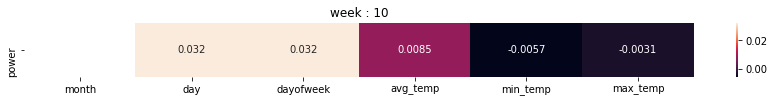

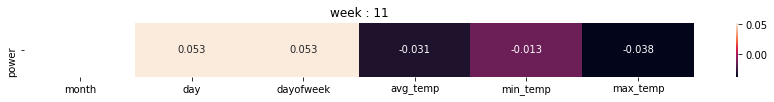

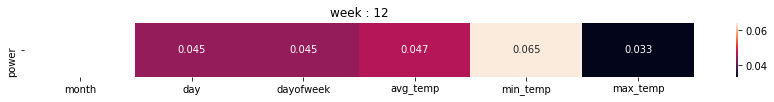

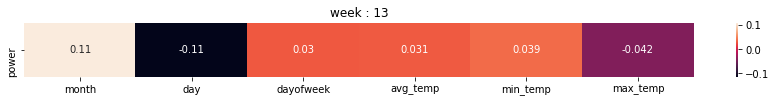

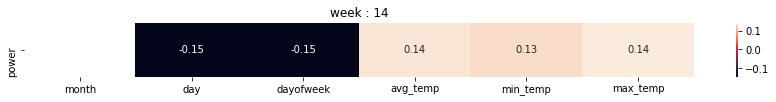

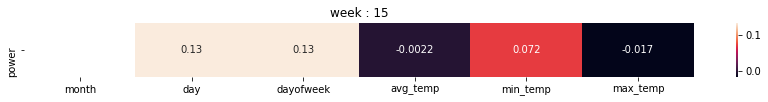

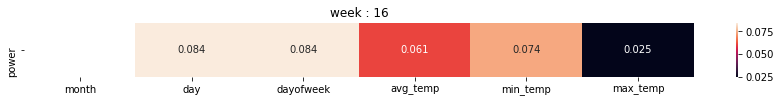

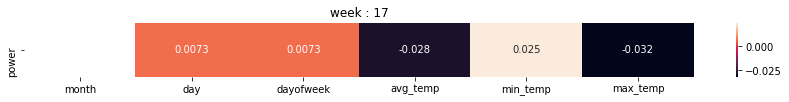

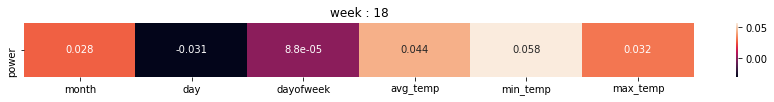

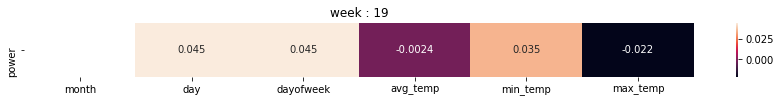

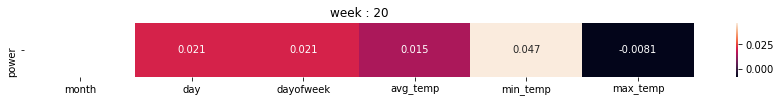

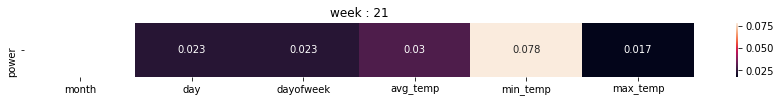

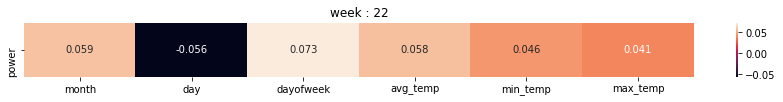

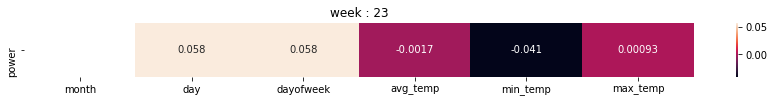

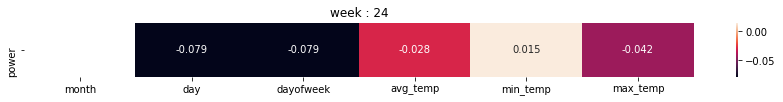

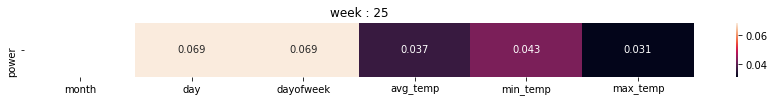

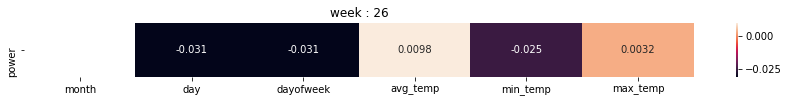

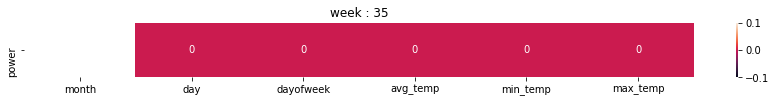

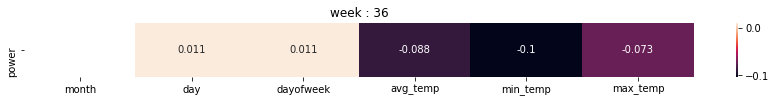

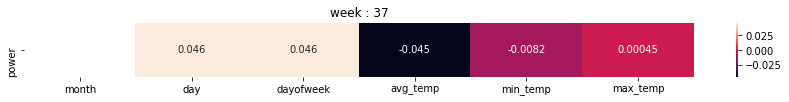

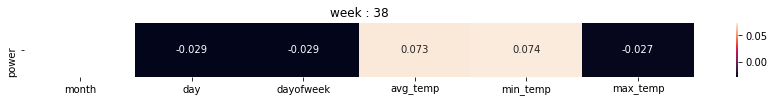

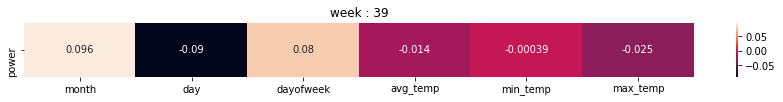

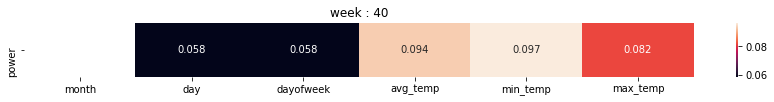

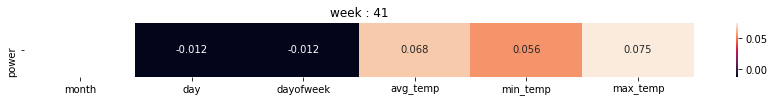

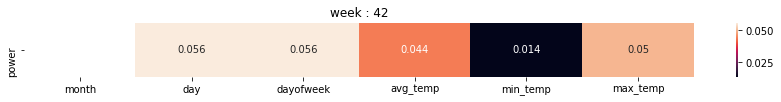

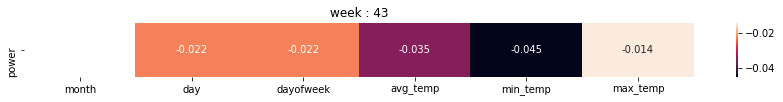

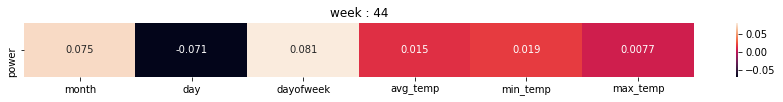

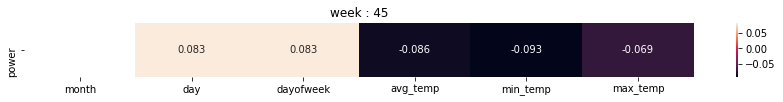

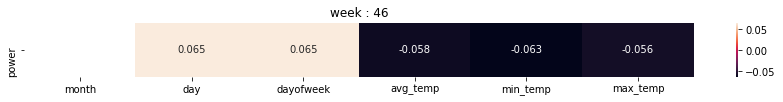

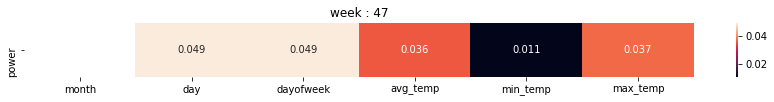

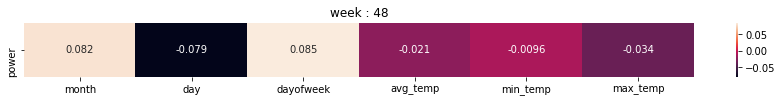

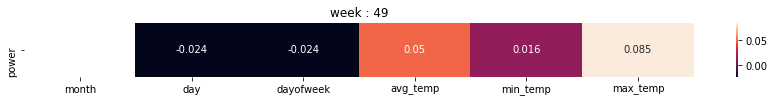

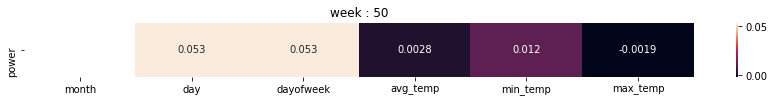

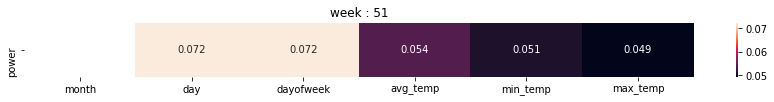

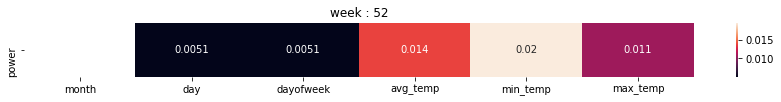

In [120]:
for w in range(1, 53):
    if w<27 or w>34:
        sns.heatmap(final_con[final_con['week']== w].corr().loc[['power'],['month', 'day', 'dayofweek', 'avg_temp', 'min_temp', 'max_temp']], annot=True)
        plt.title('week : '+ str(w))
        plt.show()

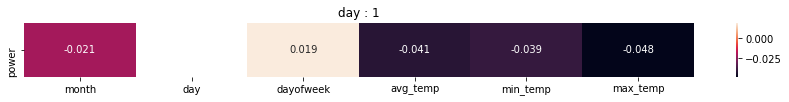

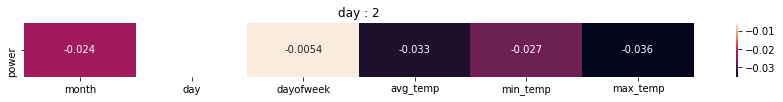

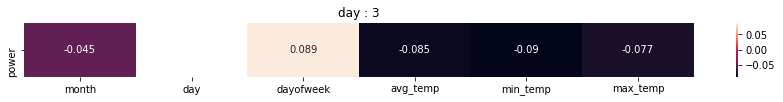

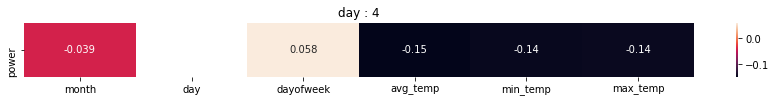

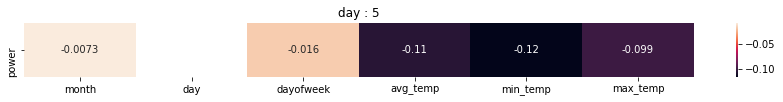

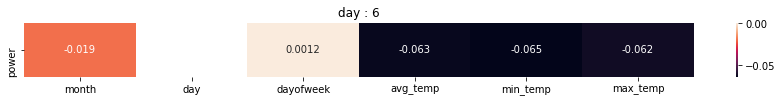

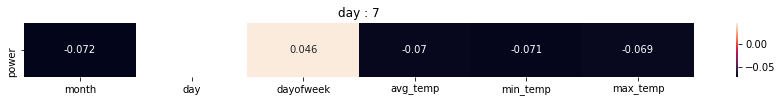

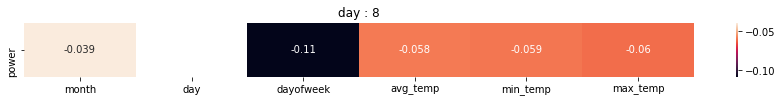

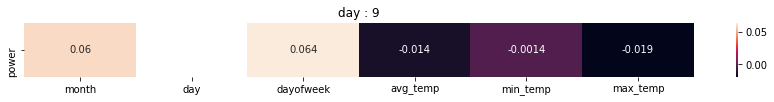

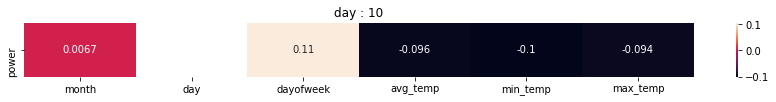

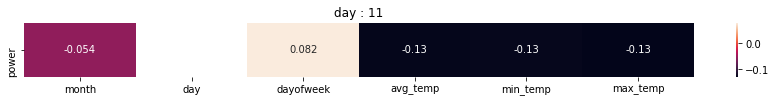

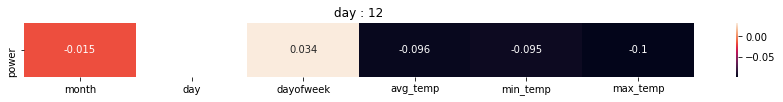

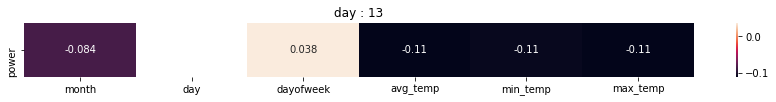

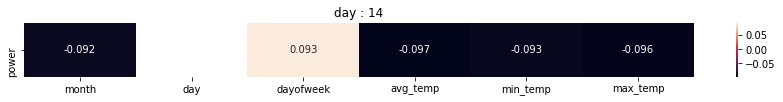

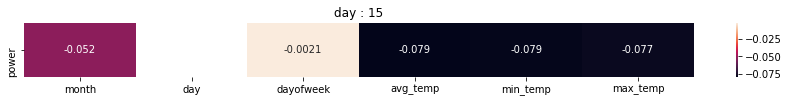

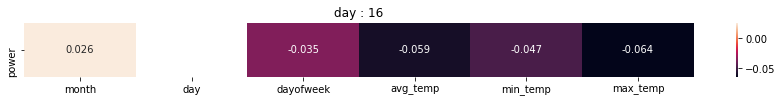

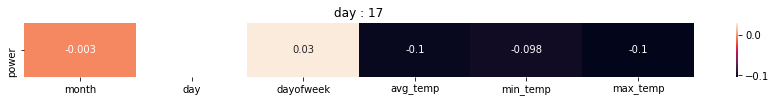

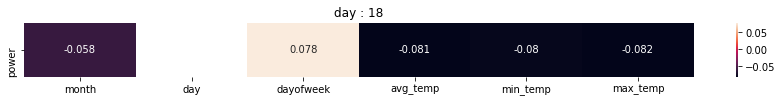

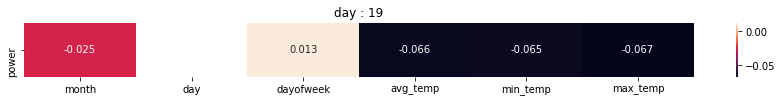

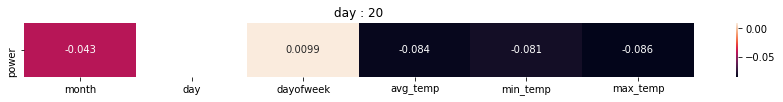

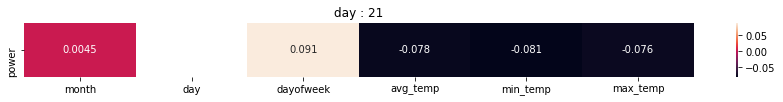

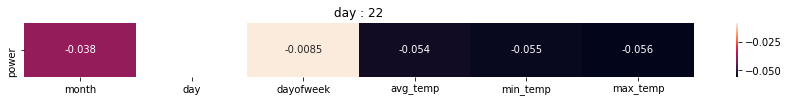

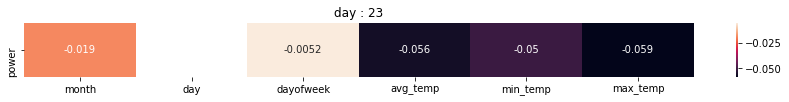

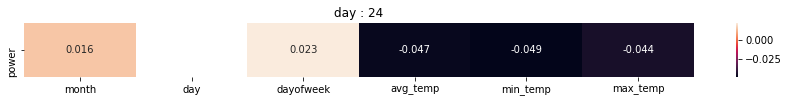

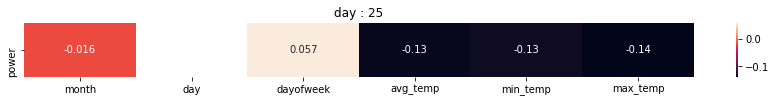

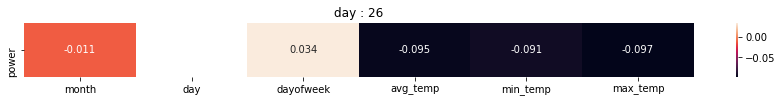

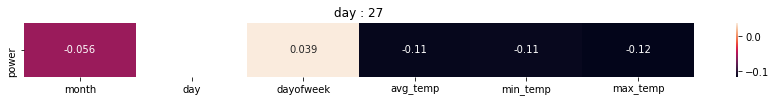

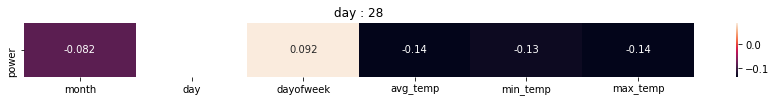

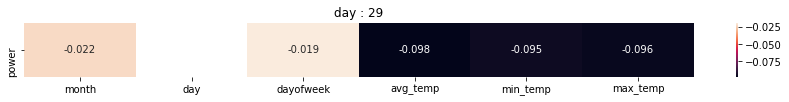

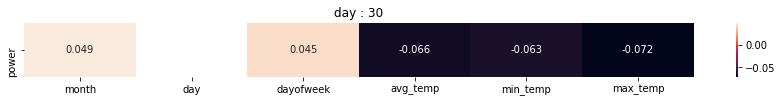

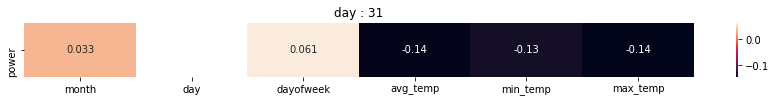

In [116]:
for d in range(1, 32):
    sns.heatmap(final_con[final_con['day']== d].corr().loc[['power'],['month', 'day', 'dayofweek', 'avg_temp', 'min_temp', 'max_temp']], annot=True)
    plt.title('day : '+ str(d))
    plt.show()

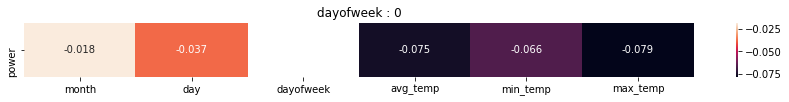

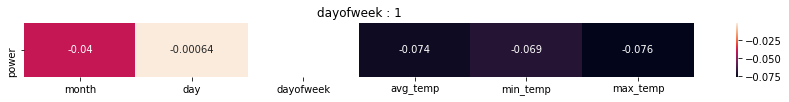

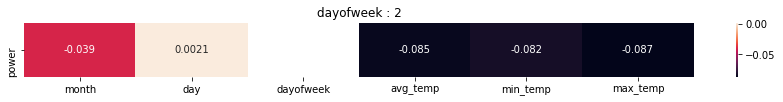

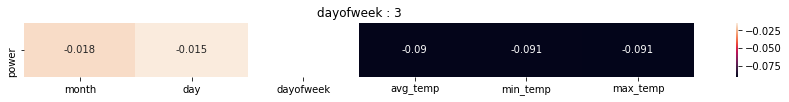

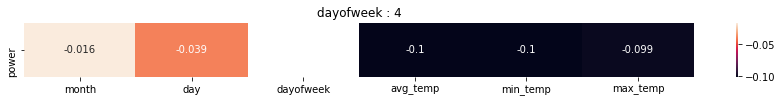

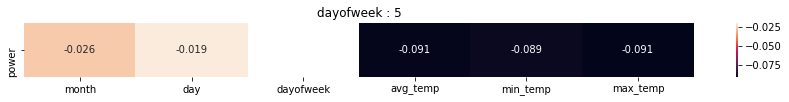

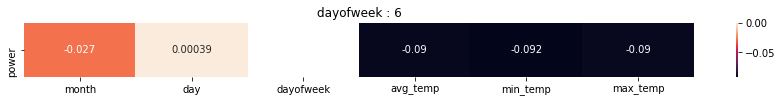

In [126]:
for d in range(0, 7):
    sns.heatmap(final_con[final_con['dayofweek']== d].corr().loc[['power'],['month', 'day', 'dayofweek', 'avg_temp', 'min_temp', 'max_temp']], annot=True)
    plt.title('dayofweek : '+ str(d))
    plt.show()

# 모델링
1) decision tree 2) randomforest tree 3) bagging 
4) adaboost 5) XGboost 6) lightGBM 7) catboost 8) DNN

# 1) decision tree

In [71]:
# Set Random Seed
seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)

# 데이터 불러오기
train_data = pd.read_csv("total_1week.csv")
test_data = pd.read_csv("total_1week_test.csv")

In [72]:
# 평가지표 SMAPE
def smape(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    '''
    This function calculates SMAPE between two lists.
    '''
    score = 100*np.mean(2*abs(predicted_values - actual_values)/(abs(predicted_values)+abs(actual_values)))
    return score

In [73]:
feature_names = ['date','avg_temp','min_temp','max_temp','rain_d','wind_d','wet_d','snow_d','year','month','week','day','dayofweek','weekend','holiday','power_d','power_d7','power_d6','power_d5','power_d4','power_d3','power_d2','power_d1']

X_train = train_data[feature_names]
y_train = train_data['power']
X_test = test_data[feature_names]
y_test = test_data['power']

tree = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5, max_features=len(feature_names), max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort='deprecated', random_state=seed, splitter='best')

In [74]:
smape_scorer = make_scorer(smape)
k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
score = cross_val_score(tree, X_train, y_train, cv=k_fold, scoring=smape_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("val_SMAPE= {0:.5f}".format(score))

tree_fit = tree.fit(X_train, y_train)
predictions = tree_fit.predict(X_test)
print(predictions.shape)
print(predictions[0:10])
test_score = smape(predictions, y_test)
print("test_SMAPE= {0:.5f}".format(test_score))

#plt.semilogy(train_data['date'], train_data['power'], label='train')
#plt.semilogy(test_data['date'], test_data['power'], label='test')
#plt.semilogy(test_data['date'], predictions, label='pred')
#plt.legend()

# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")



Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '2018-02-22'

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '2018-02-22'

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '2018-02-22'

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '2018-02-22'

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '2018-02-22'

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not c

val_SMAPE= nan


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '2018-02-22'



ValueError: could not convert string to float: '2018-02-22'

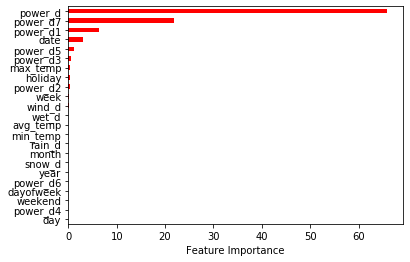

In [30]:
# 특성 중요도 검사 방법 1
Importance = pd.DataFrame({'Importance':tree.feature_importances_*100}, 
                          index = X_train.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Feature Importance')
plt.gca().legend_ = None

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


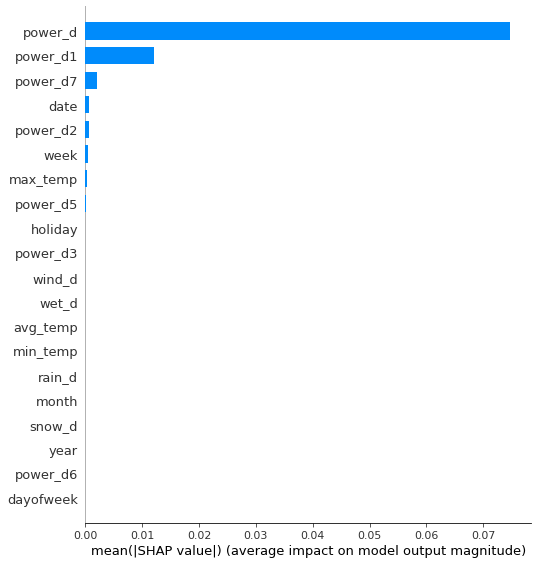

In [31]:
# 특성 중요도 검사 방법 2
explainer = shap.TreeExplainer(tree) # 트리 모델 Shap Value 계산 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산
shap.summary_plot(shap_values, X_test, plot_type = "bar")

# 2) Random forest

In [32]:
rand_tree = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=len(feature_names), max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=seed, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)

val_SMAPE= 15.42843
(45411,)
[0.50970292 0.65224875 0.49955475 0.69685598 0.56584991 0.55327415
 0.55464873 0.64850142 0.64857129 0.62982816]
test_SMAPE= 15.09587


[Text(0.5, 1.0, 'test')]

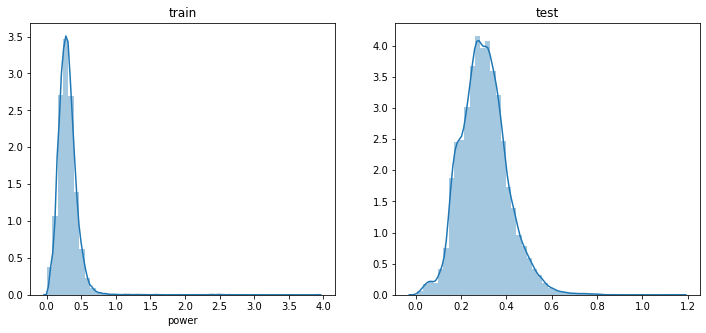

In [33]:
smape_scorer = make_scorer(smape)
k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
score = cross_val_score(rand_tree, X_train, y_train, cv=k_fold, scoring=smape_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("val_SMAPE= {0:.5f}".format(score))

rand_tree_fit = rand_tree.fit(X_train, y_train)
predictions = rand_tree_fit.predict(X_test)
print(predictions.shape)
print(predictions[0:10])
test_score = smape(predictions, y_test)
print("test_SMAPE= {0:.5f}".format(test_score))
#plt.semilogy(train_data['date'], train_data['power'], label='train')
#plt.semilogy(test_data['date'], test_data['power'], label='test')
#plt.semilogy(test_data['date'], price_tree, label='pred')
#plt.legend()

# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

In [ ]:
explainer = shap.TreeExplainer(rand_tree) # 트리 모델 Shap Value 계산 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산
shap.summary_plot(shap_values, X_test, plot_type = "bar")

# 3) Bagging

In [ ]:
bagging_tree = BaggingRegressor(base_estimator=tree, n_estimators=30, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=seed, verbose=0)

#  to csv

In [ ]:
def to_csv_section_mean(week):
    final_ans = PreModel_section(train_2, meter_ids, week)
    final_ans.to_csv("problem_section_mean_week{}.csv".format(week),mode='w')
def to_csv_total_mean(week):
    final_ans = PreModel_total(train_2, meter_ids, week)
    final_ans.to_csv("problem_total_mean_week{}.csv".format(week),mode='w')
                                        
def to_csv_pre_value(week):
    final_ans = PreModel_prev(train_2, meter_ids, week)
    final_ans.to_csv("problem_prev_val_week{}.csv".format(week),mode='w')                                                               
    

In [ ]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('ERROR : Creating directory. ' + directory)

In [ ]:
# case 1: total
# case 2: section
# case 3: prev_val
def save_csv(case):
    for i in range(1,4):
        if case == 1:
            if i == 1:
                createFolder('/Users/ILIFO-009/미니프로젝트 관련/git/final_ans_total_mean')
                os.chdir('final_ans_total_mean')
            to_csv_total_mean(i)
            if i == 3:
                os.chdir("..")
        if case == 2:
            if i == 1:
                createFolder('/Users/ILIFO-009/미니프로젝트 관련/git/final_ans_section_mean')
                os.chdir('final_ans_section_mean')
            to_csv_total_mean(i)
            if i == 3:
                os.chdir("..")
        if case == 3:
            if i == 1:
                createFolder('/Users/ILIFO-009/미니프로젝트 관련/git/final_ans_prev_val')
                os.chdir('final_ans_prev_val')
            to_csv_total_mean(i)
            if i == 3:
                os.chdir("..")

      